## PyTorch (alternative framework)

In [1]:
import torch
%matplotlib inline
import numpy as np
import pandas as pd
#%matplotlib widget
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

## Model Exmaple with generated data

Training the model...
Epoch [20/100], Loss: 0.0477, Accuracy: 0.9912
Epoch [40/100], Loss: 0.0347, Accuracy: 0.9938
Epoch [60/100], Loss: 0.0200, Accuracy: 0.9950
Epoch [80/100], Loss: 0.0168, Accuracy: 0.9962
Epoch [100/100], Loss: 0.0144, Accuracy: 0.9962

Test Accuracy: 0.9850
Test Loss: 0.6626


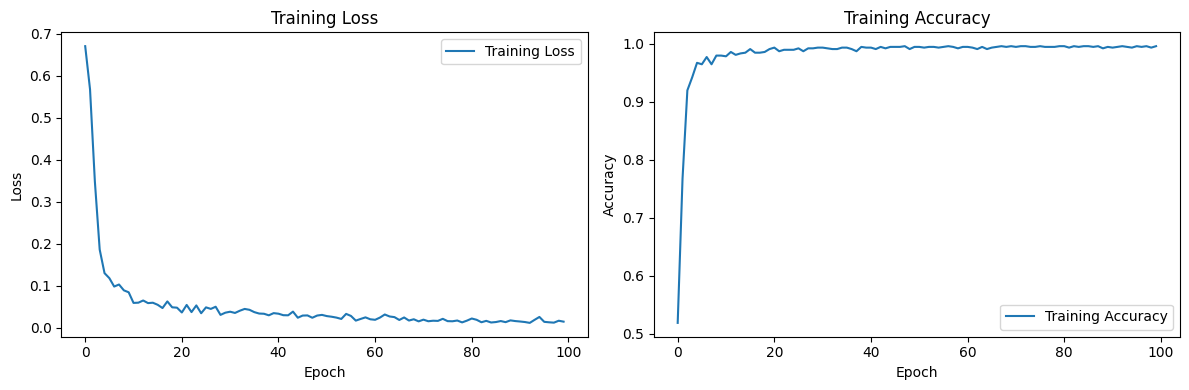


Example predictions:
Sample 1: Probability=1.000, Predicted=1, Actual=1
Sample 2: Probability=1.000, Predicted=1, Actual=1
Sample 3: Probability=0.000, Predicted=0, Actual=0
Sample 4: Probability=0.000, Predicted=0, Actual=0
Sample 5: Probability=1.000, Predicted=1, Actual=1

Model saved!
Predictions from loaded model: [9.99995708e-01 1.00000000e+00 2.70055811e-04 1.08394415e-05
 1.00000000e+00]

Total trainable parameters: 3,969
Model architecture:
NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Generate dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                          n_redundant=10, n_clusters_per_class=1, random_state=42)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = NeuralNetwork(input_size=20, hidden_sizes=[64, 32, 16], output_size=1)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
train_accuracies = []

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted = (test_outputs > 0.5).float()
    test_accuracy = (test_predicted == y_test_tensor).float().mean()
    test_loss = criterion(test_outputs, y_test_tensor)
    
    print(f'\nTest Accuracy: {test_accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}')

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions_prob = predictions.numpy()
    predictions_binary = (predictions > 0.5).numpy().astype(int)

print("\nExample predictions:")
for i in range(5):
    prob = predictions_prob[i][0]
    pred_class = predictions_binary[i][0]
    actual_class = y_test[i]
    print(f"Sample {i+1}: Probability={prob:.3f}, Predicted={pred_class}, Actual={actual_class}")

# Save the model
torch.save(model.state_dict(), 'pytorch_model.pth')
torch.save(model, 'pytorch_model_complete.pth')
print("\nModel saved!")

# Load the model
loaded_model = NeuralNetwork(input_size=20, hidden_sizes=[64, 32, 16], output_size=1)
loaded_model.load_state_dict(torch.load('pytorch_model.pth'))
loaded_model.eval()

# Verify loaded model works
with torch.no_grad():
    new_predictions = loaded_model(X_test_tensor[:5])
    print("Predictions from loaded model:", new_predictions.numpy().flatten())

# Model summary (custom function since PyTorch doesn't have built-in summary)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")
print("Model architecture:")
print(model)

In [3]:
df = pd.read_csv('data/sonar.csv', engine='pyarrow')
df.head()

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,0.2988,0.4250,0.6343,0.8198,1.0000,0.9988,0.9508,0.9025,0.7234,0.5122,0.2074,0.3985,0.5890,0.2872,0.2043,0.5782,0.5389,0.3750,0.3411,0.5067,0.5580,0.4778,0.3299,0.2198,0.1407,0.2856,0.3807,0.4158,0.4054,0.3296,0.2707,0.2650,0.0723,0.1238,0.1192,0.1089,0.0623,0.0494,0.0264,0.0081,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [4]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)

missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (207, 61)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['0.0200', '0.0371', '0.0428', '0.0207', '0.0954', '0.0986', '0.1539', '0.1601', '0.3109', '0.2111', '0.1609', '0.1582', '0.2238', '0.0645', '0.0660', '0.2273', '0.3100', '0.2999', '0.5078', '0.4797', '0.5783', '0.5071', '0.4328', '0.5550', '0.6711', '0.6415', '0.7104', '0.8080', '0.6791', '0.3857', '0.1307', '0.2604', '0.5121', '0.7547', '0.8537', '0.8507', '0.6692', '0.6097', '0.4943', '0.2744', '0.0510', '0.2834', '0.2825', '0.4256', '0.2641', '0.1386', '0.1051', '0.1343', '0.0383', '0.0324', '0.0232', '0.0027', '0.0065', '0.0159', '0.0072', '0.0167', '0.0180', '0.0084', '0.0090', '0.0032', 'R']
-------------------------------------------------------------------

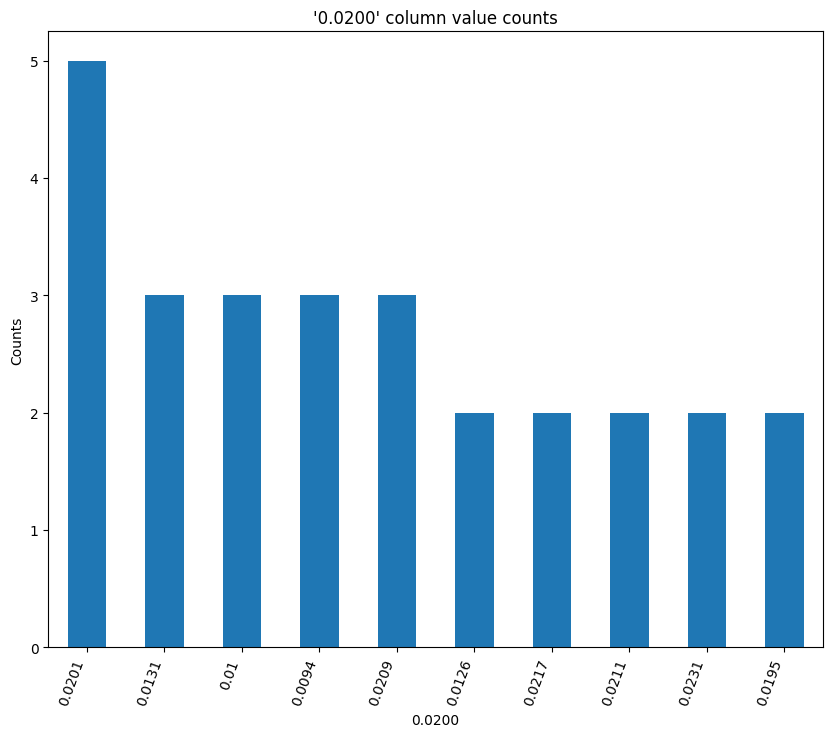

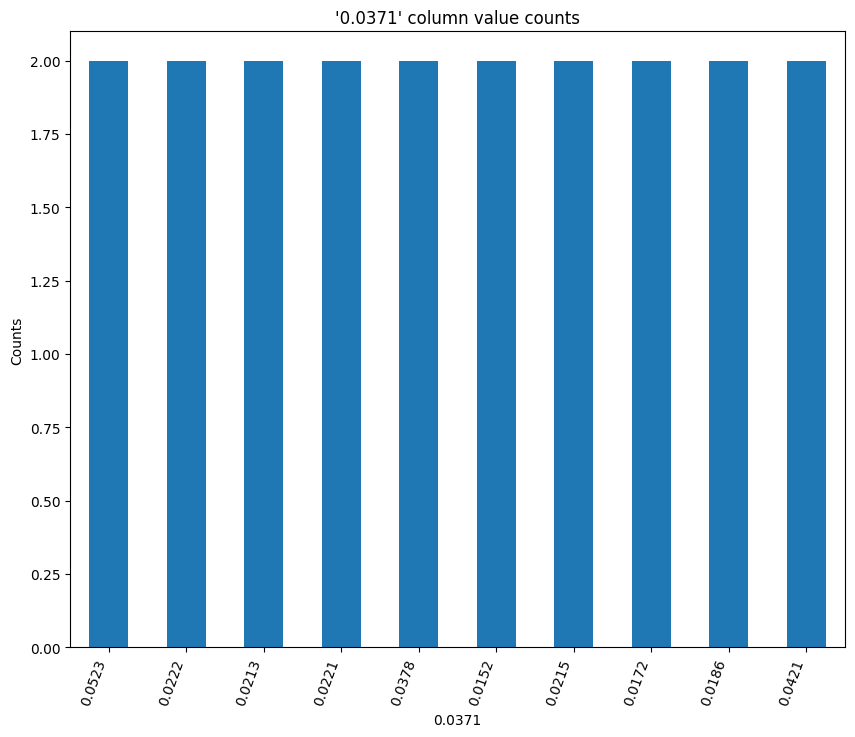

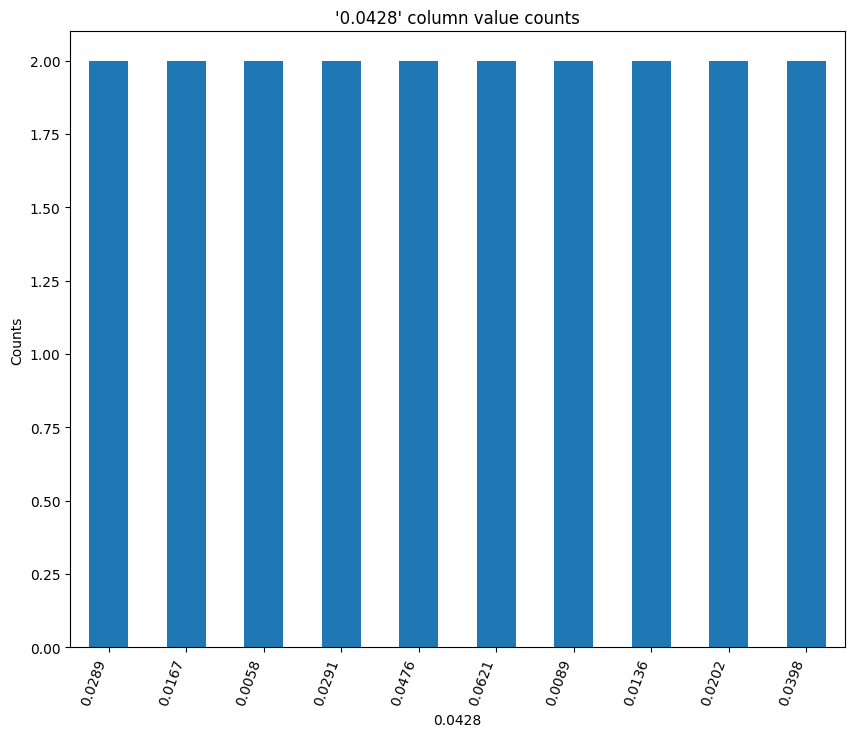

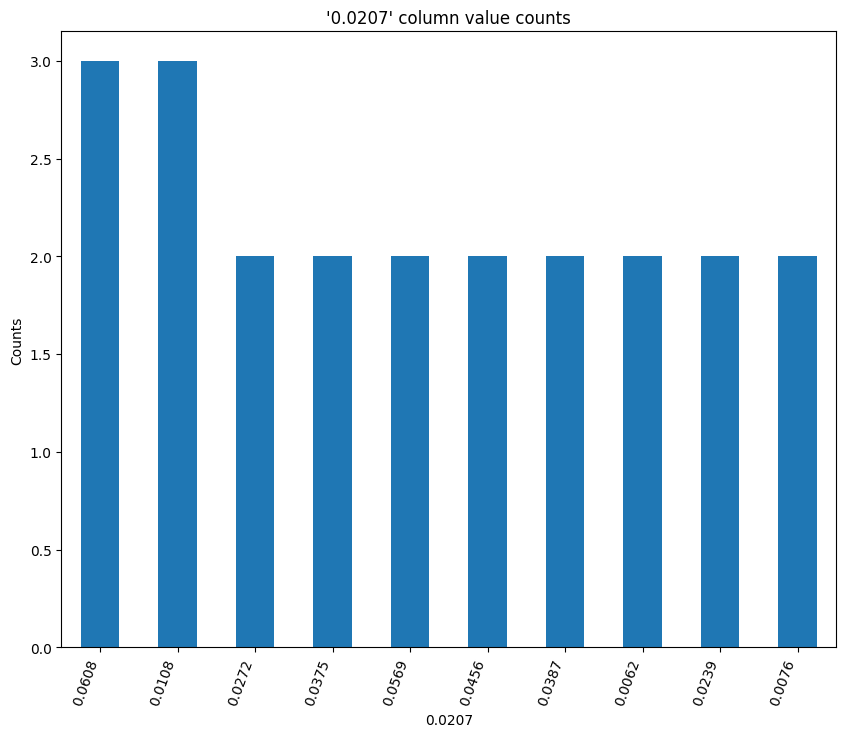

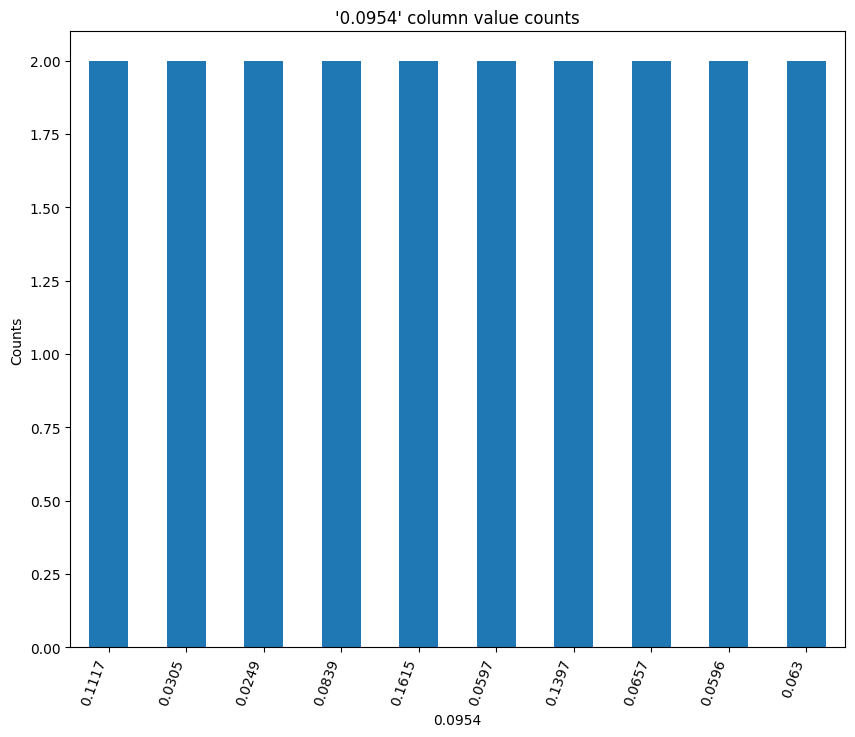

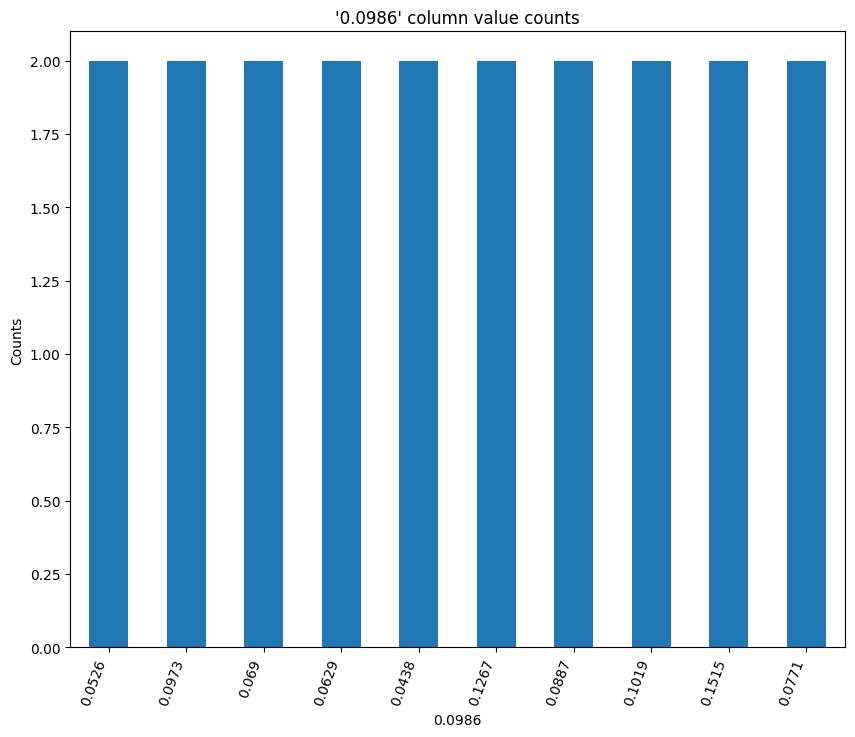

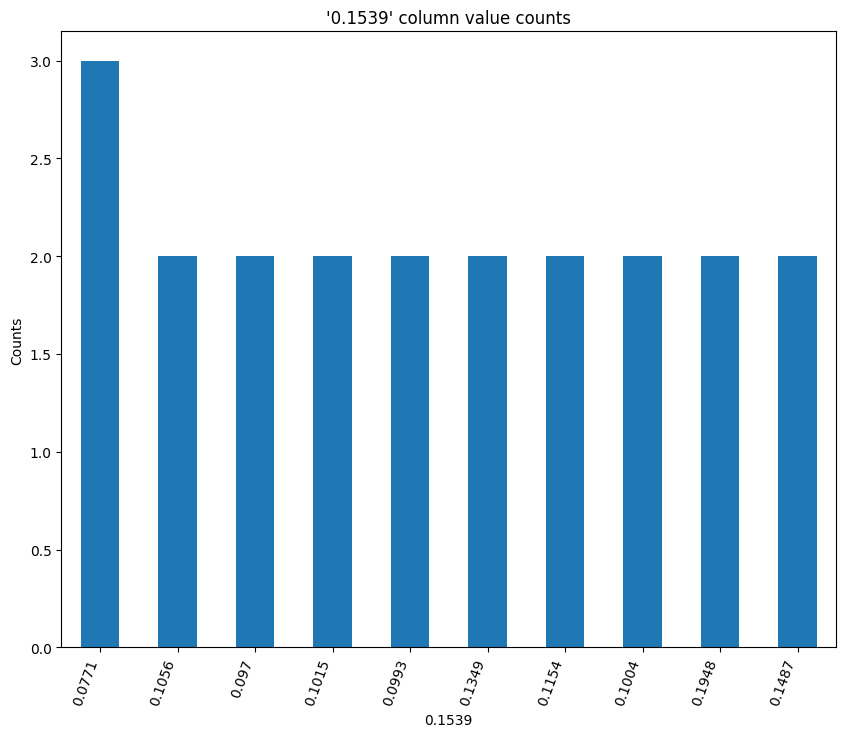

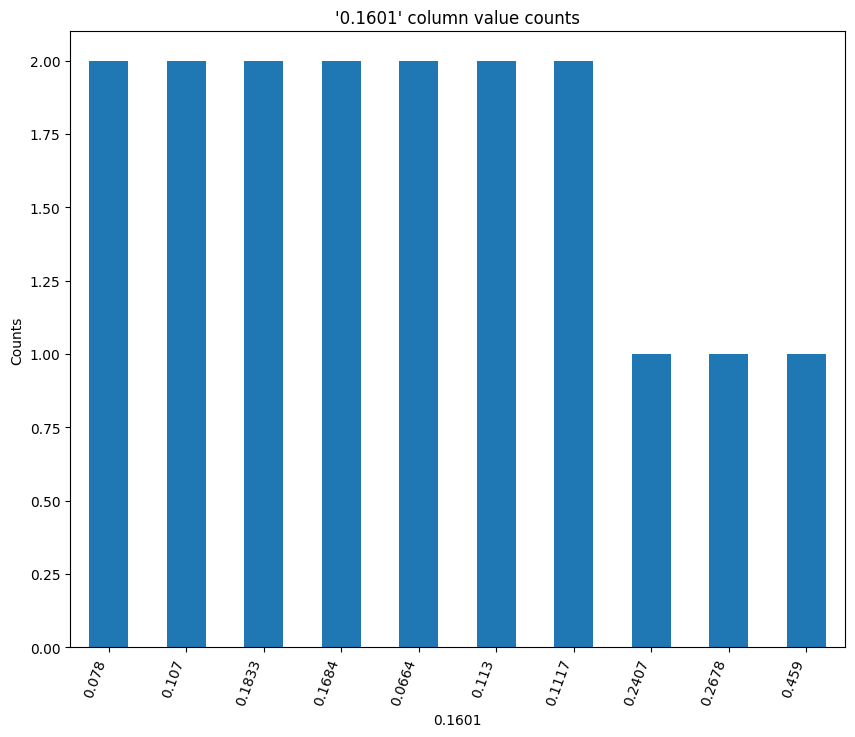

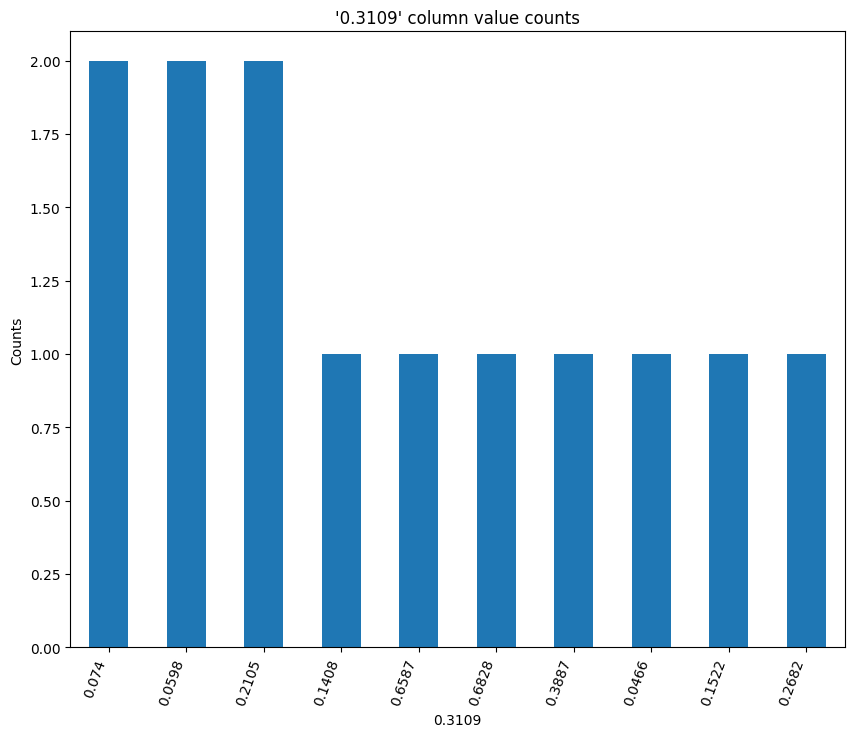

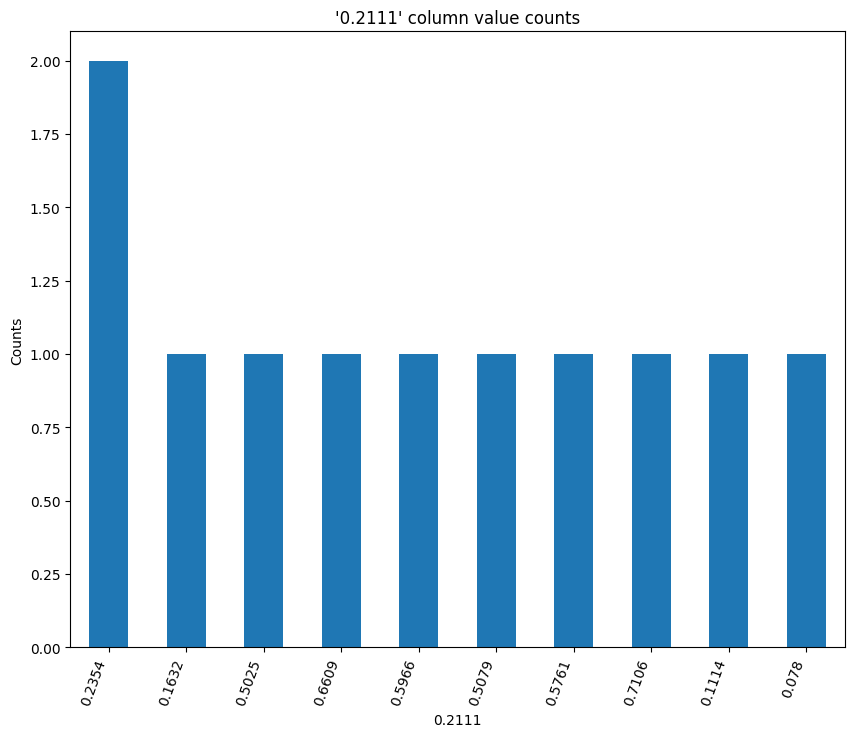

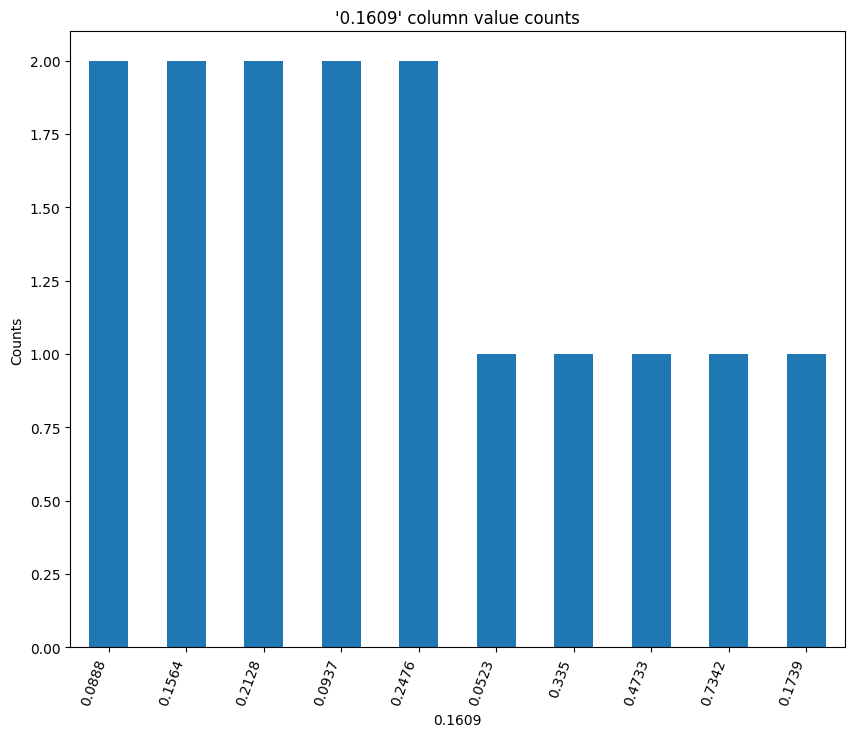

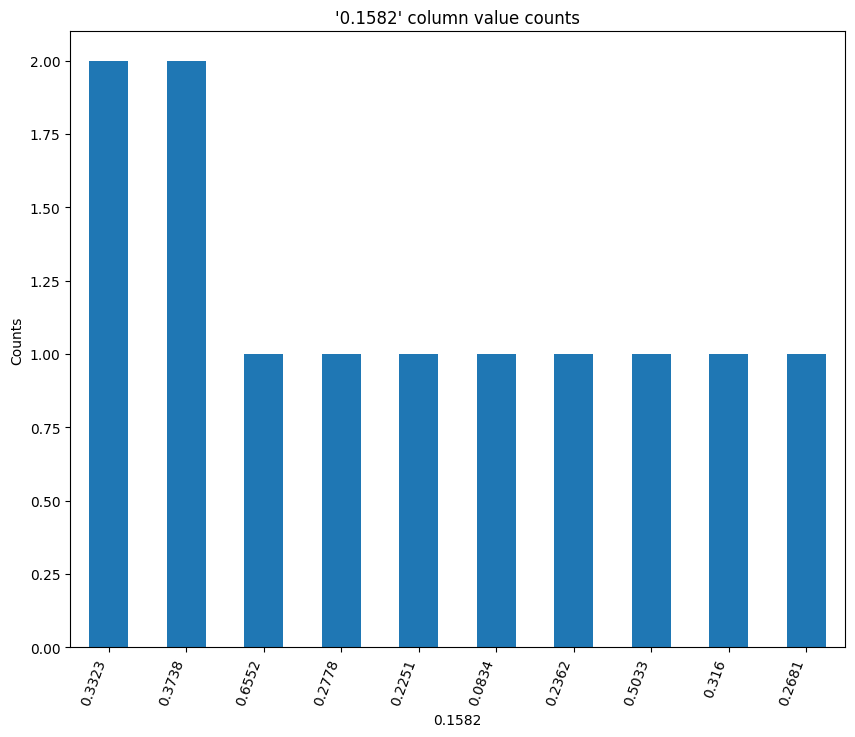

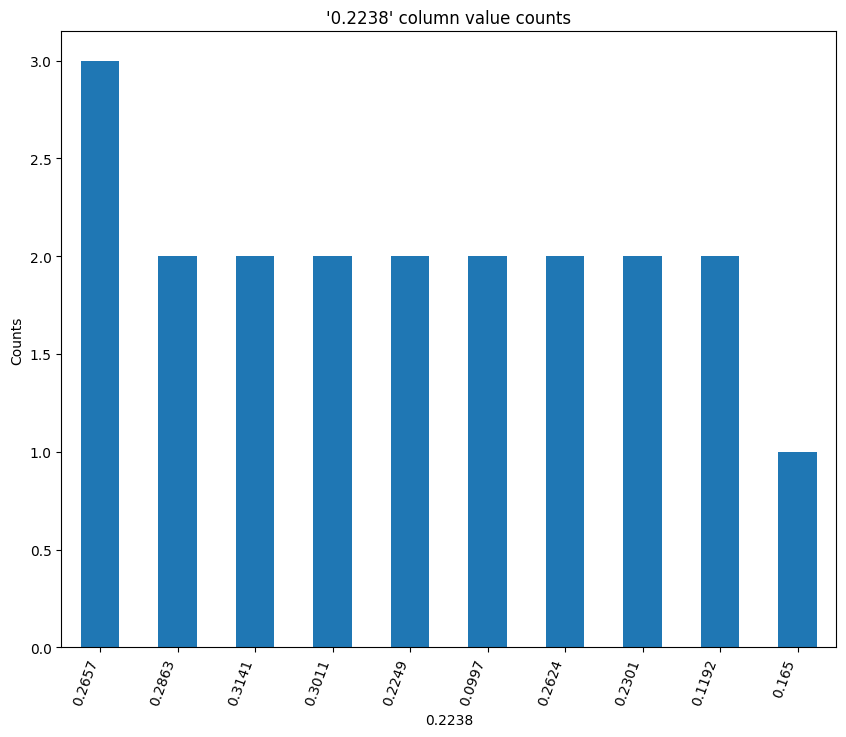

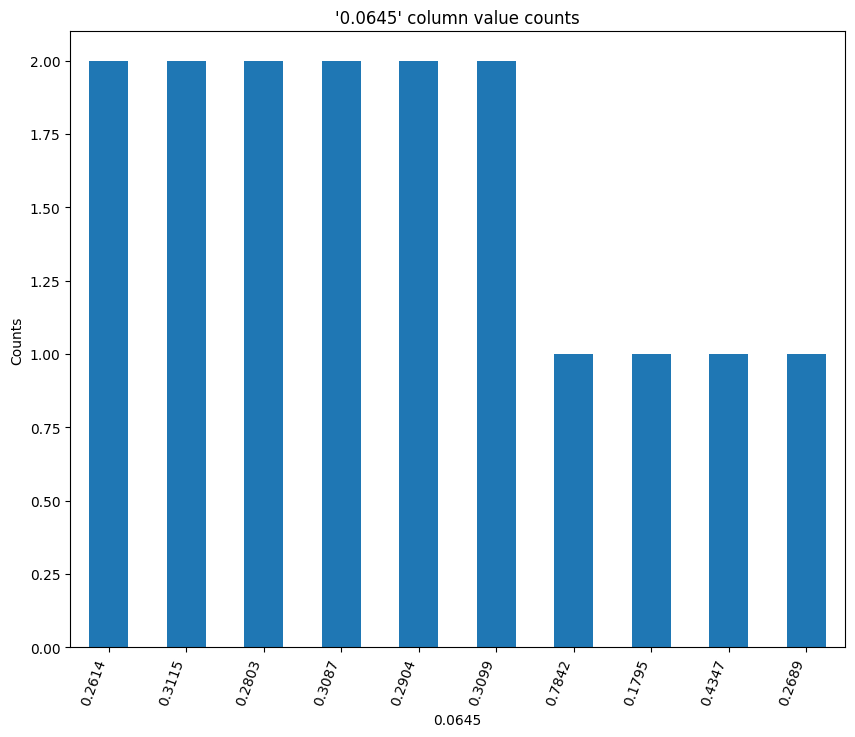

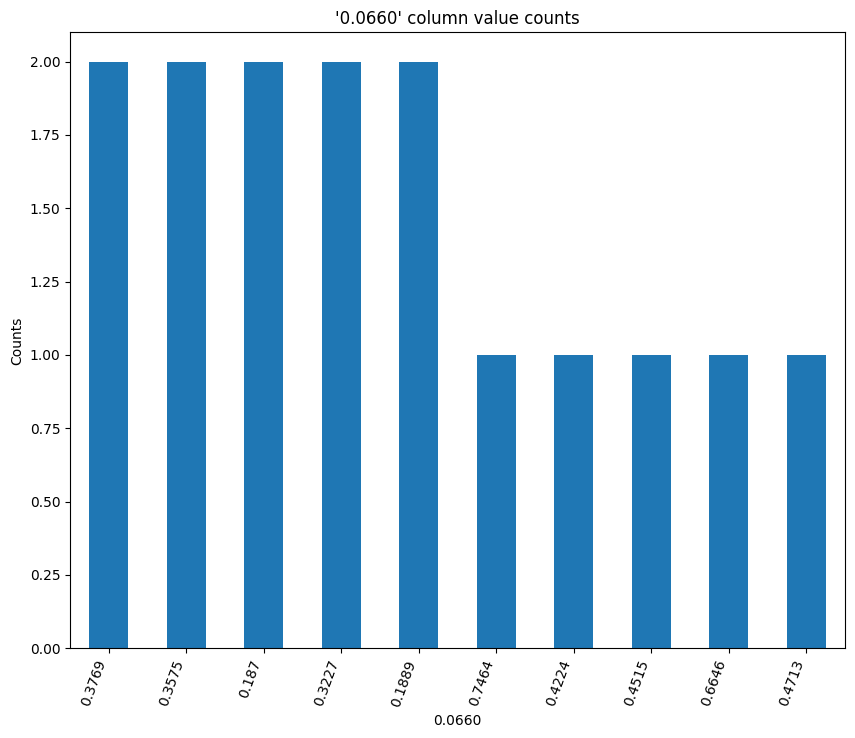

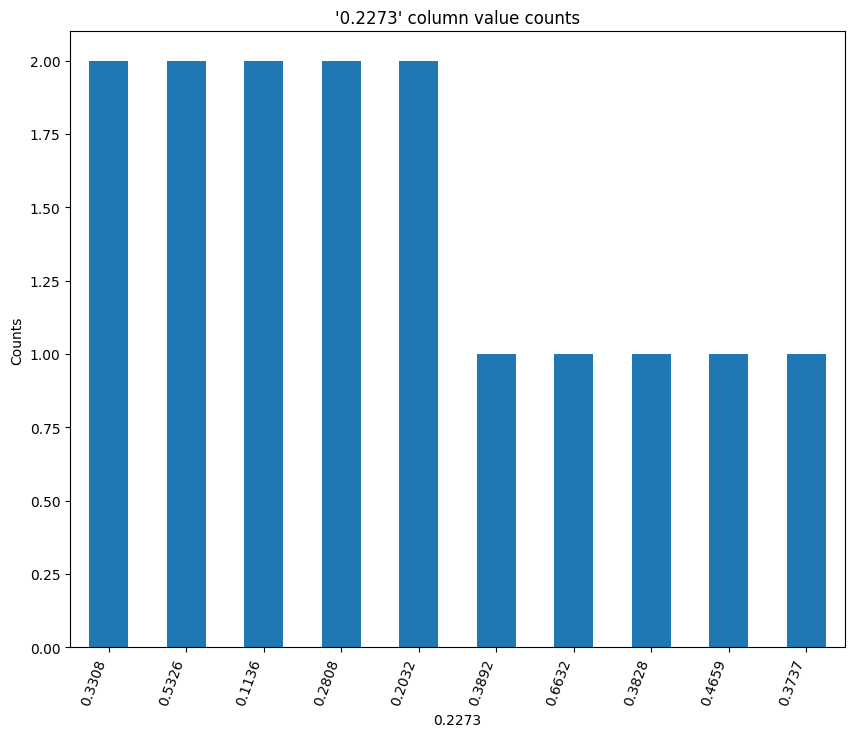

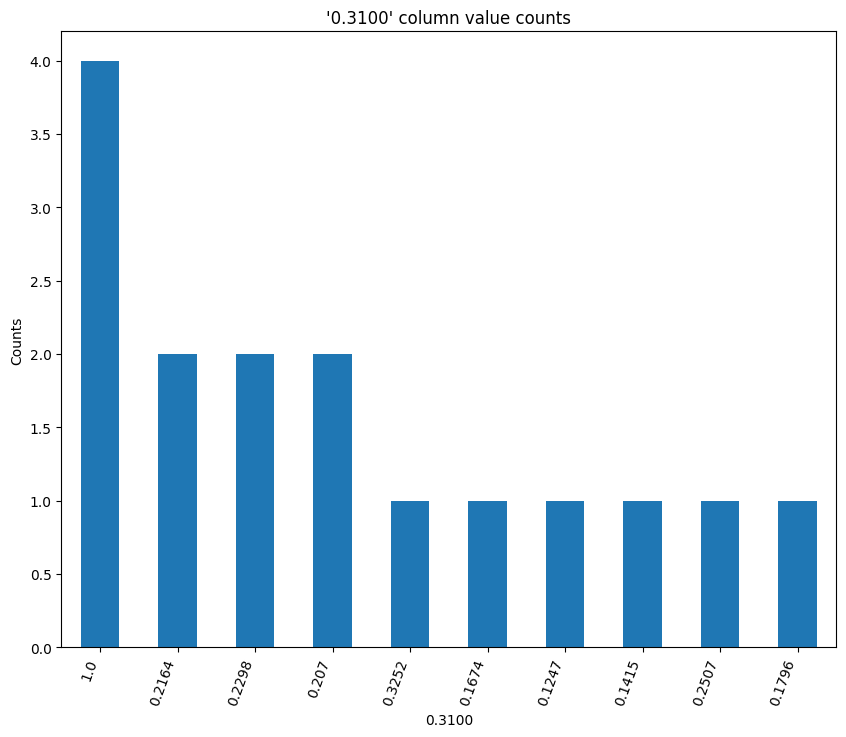

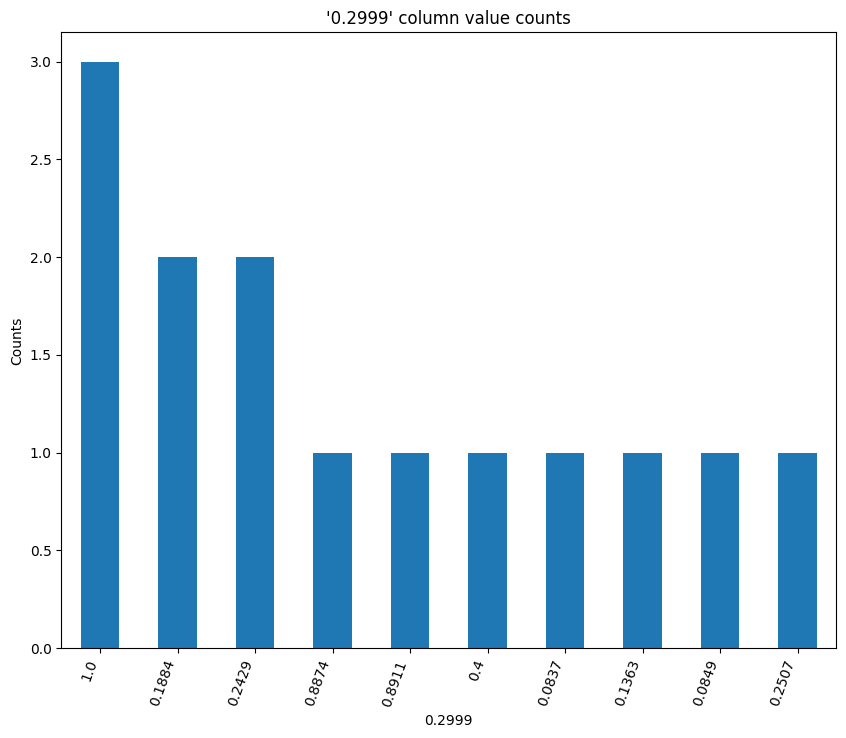

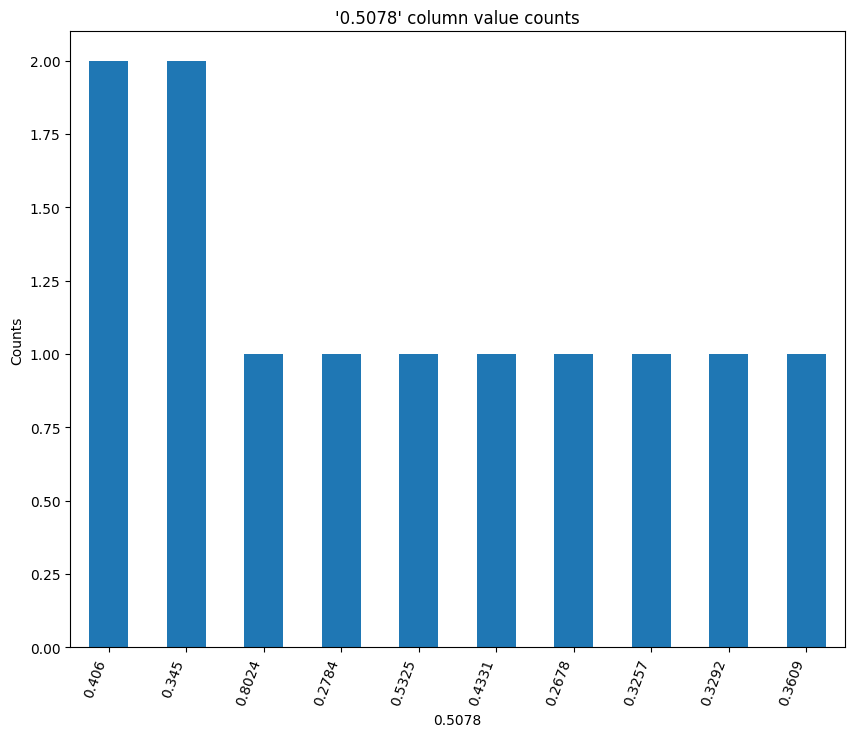

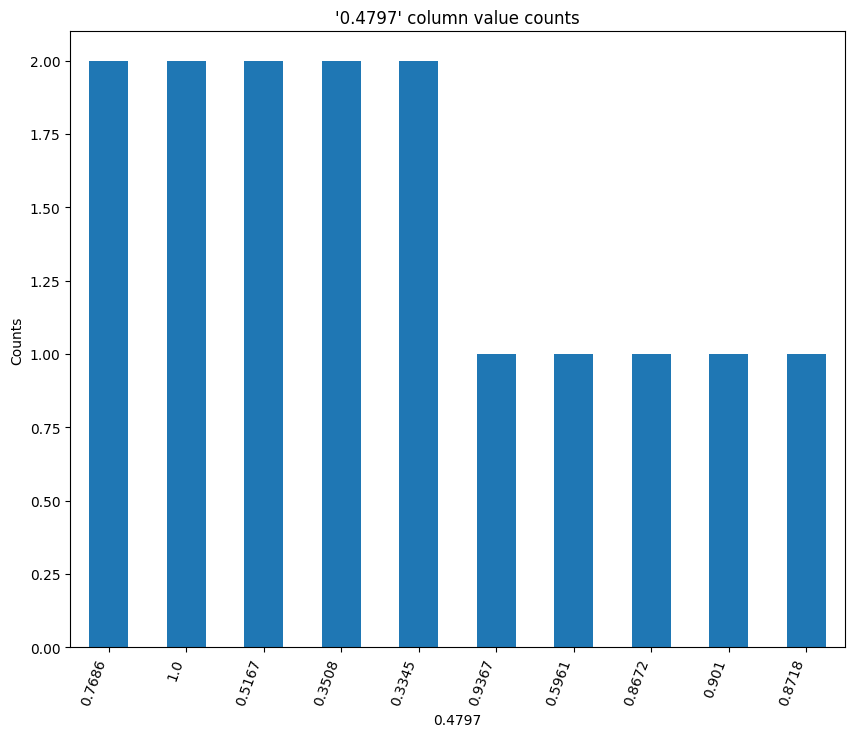

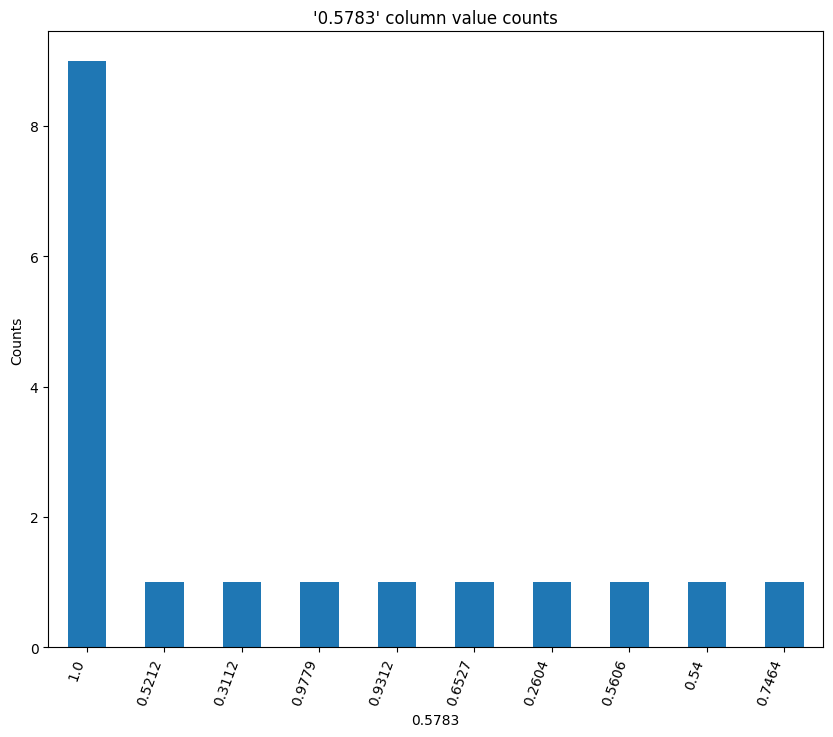

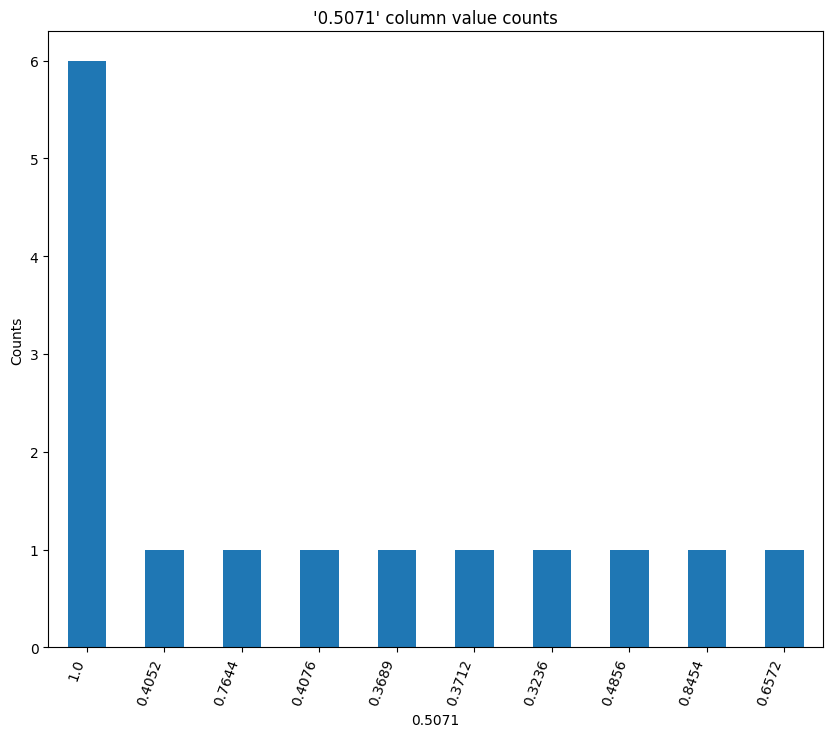

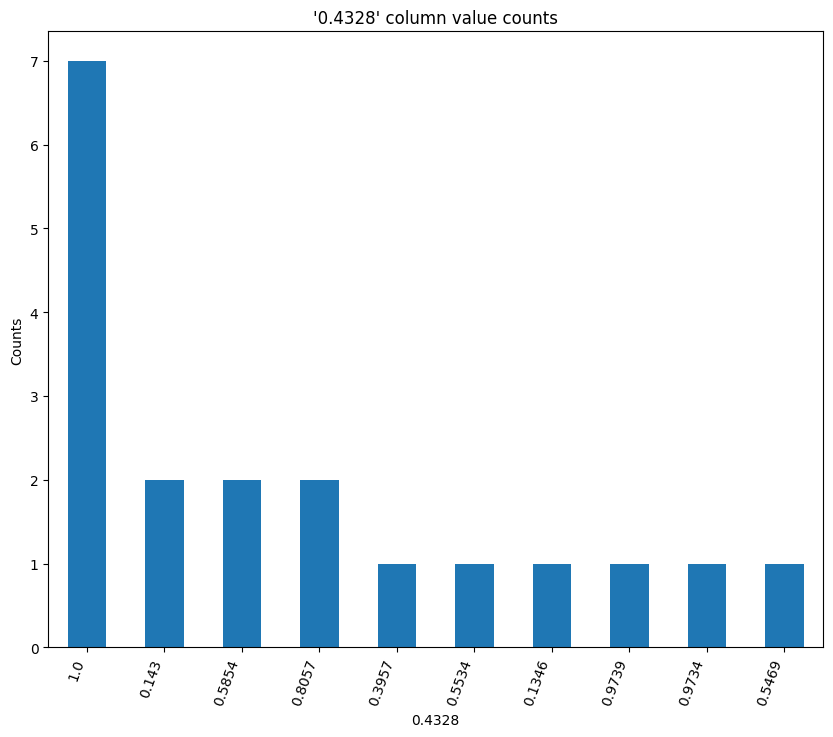

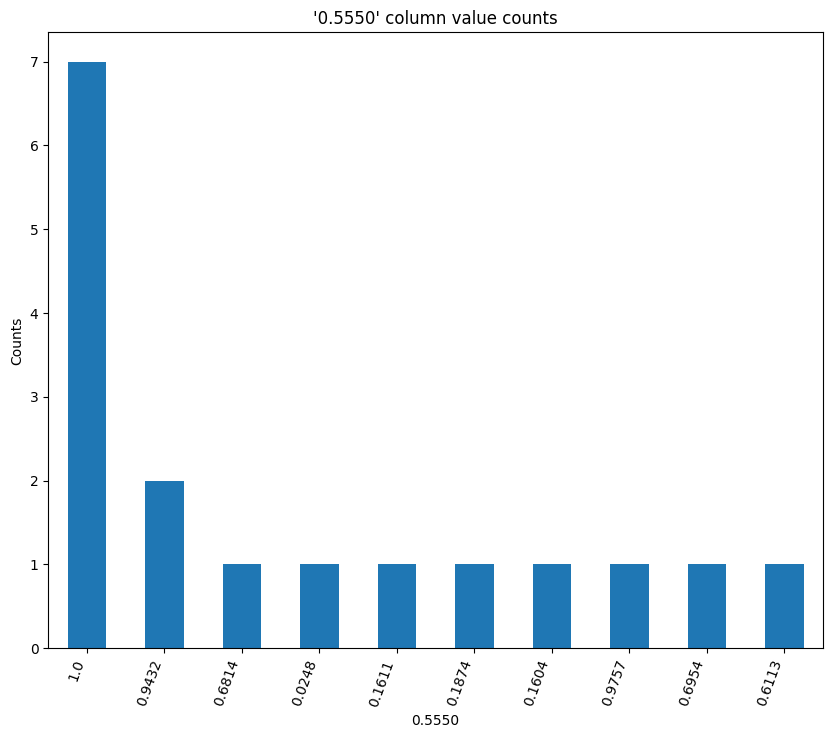

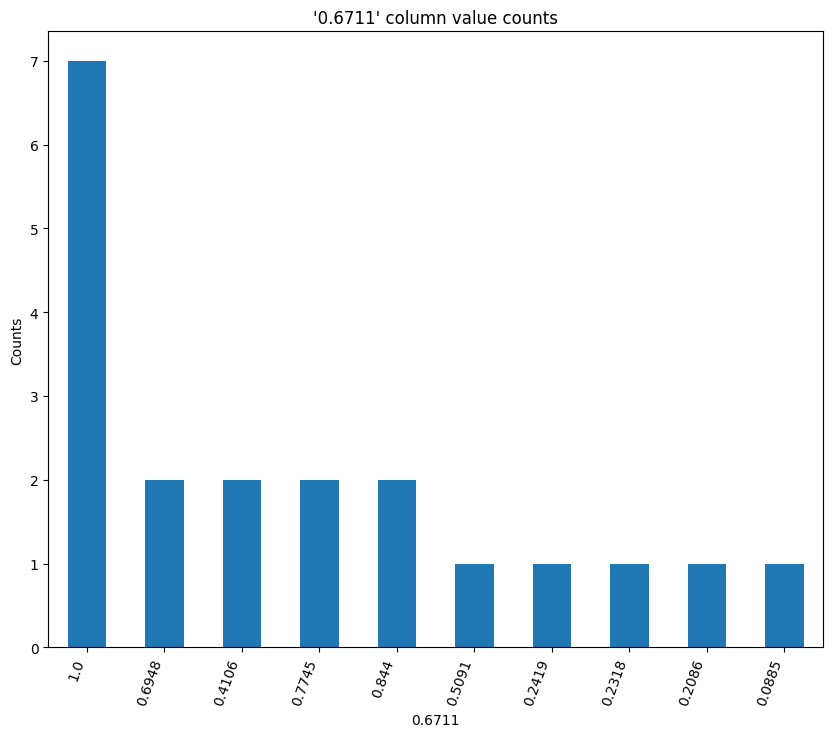

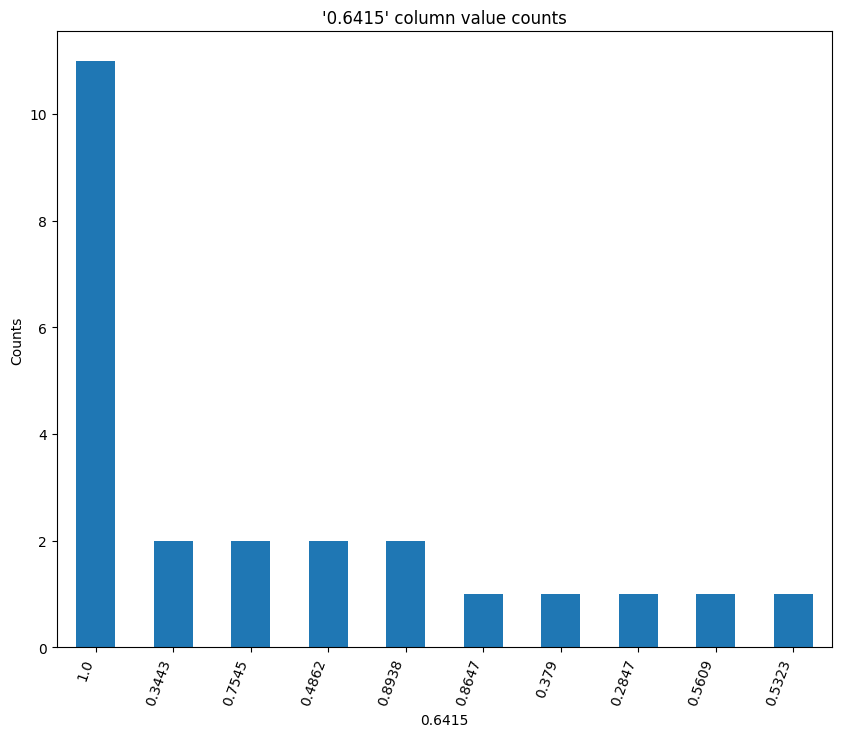

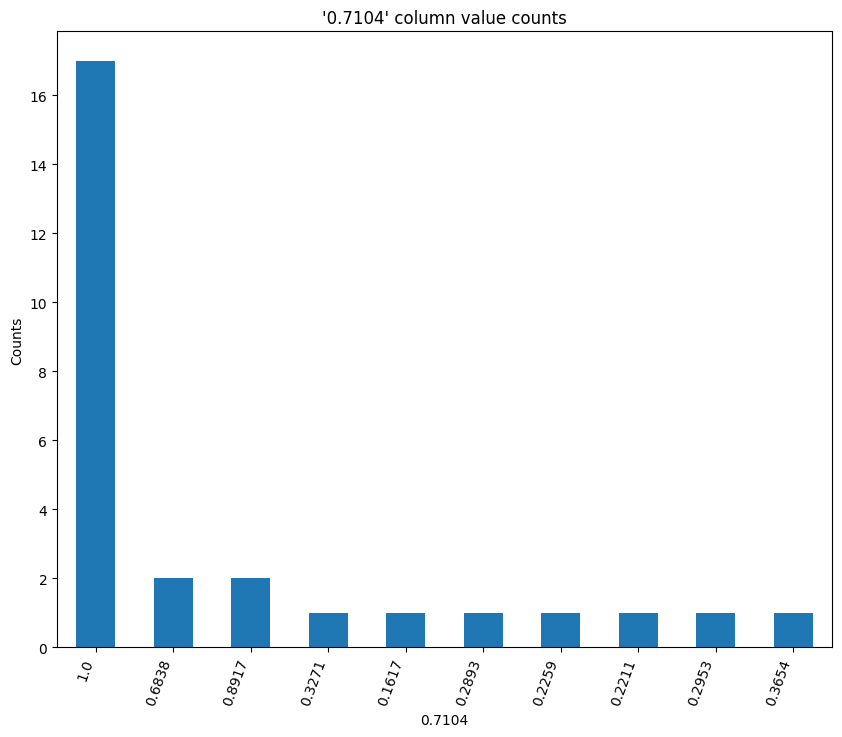

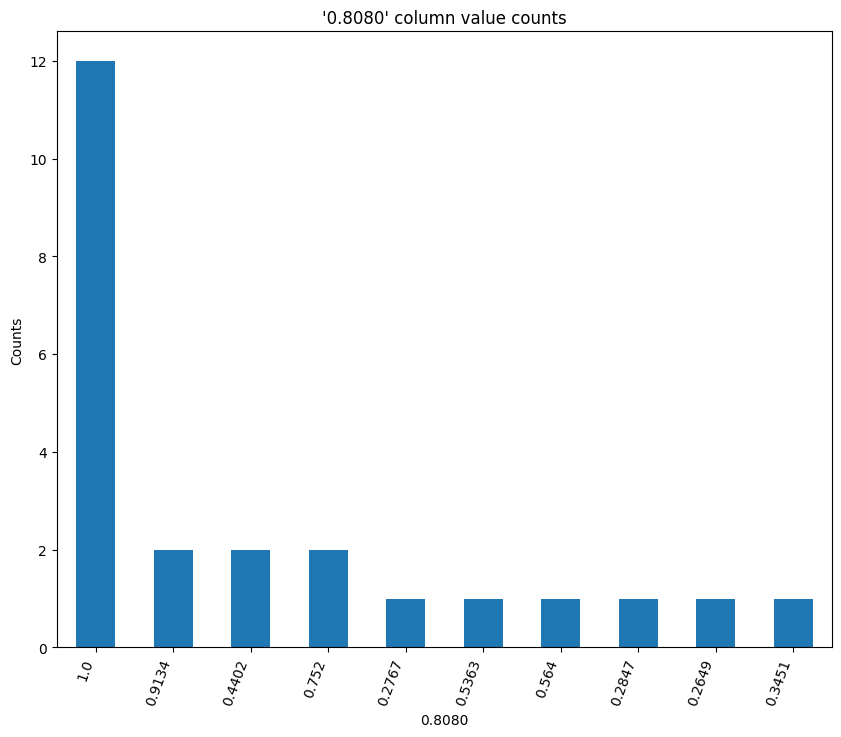

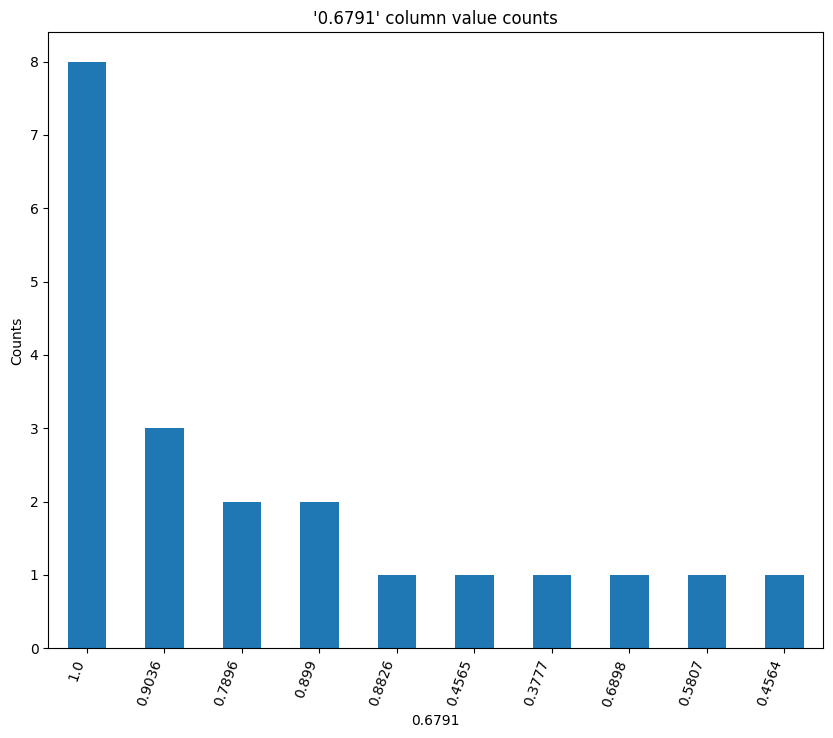

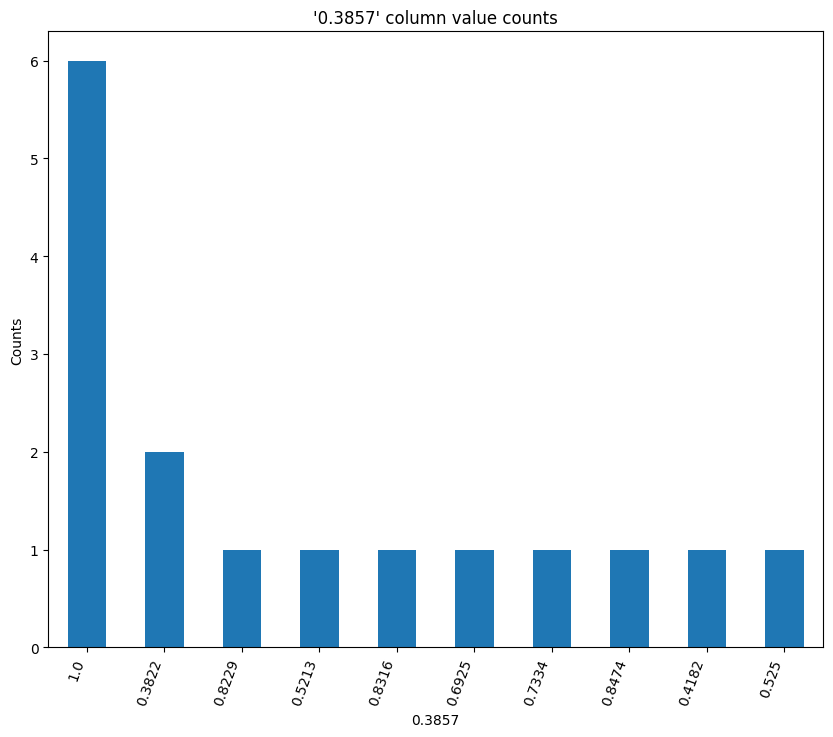

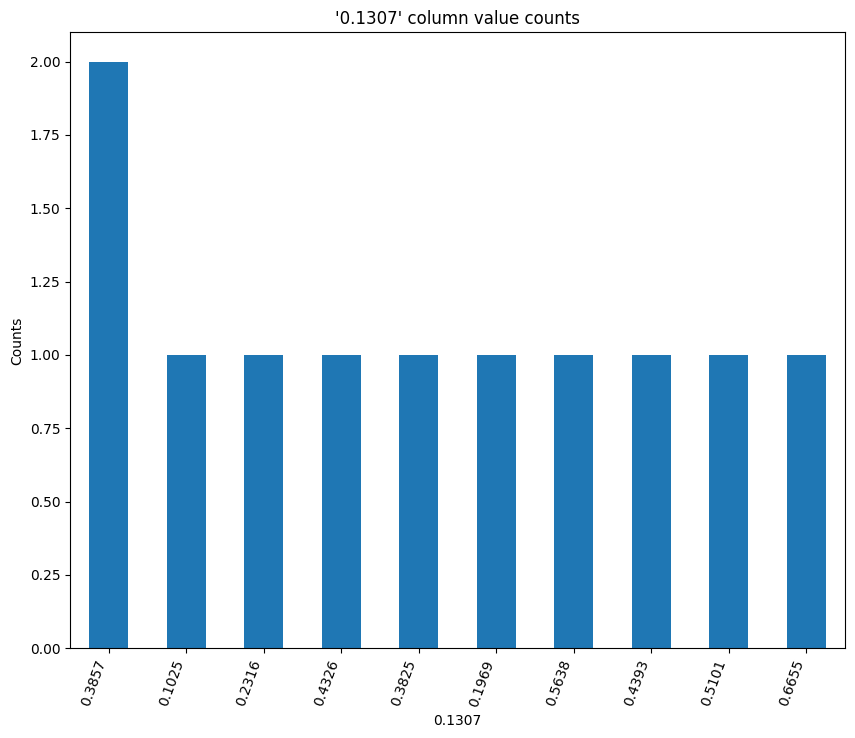

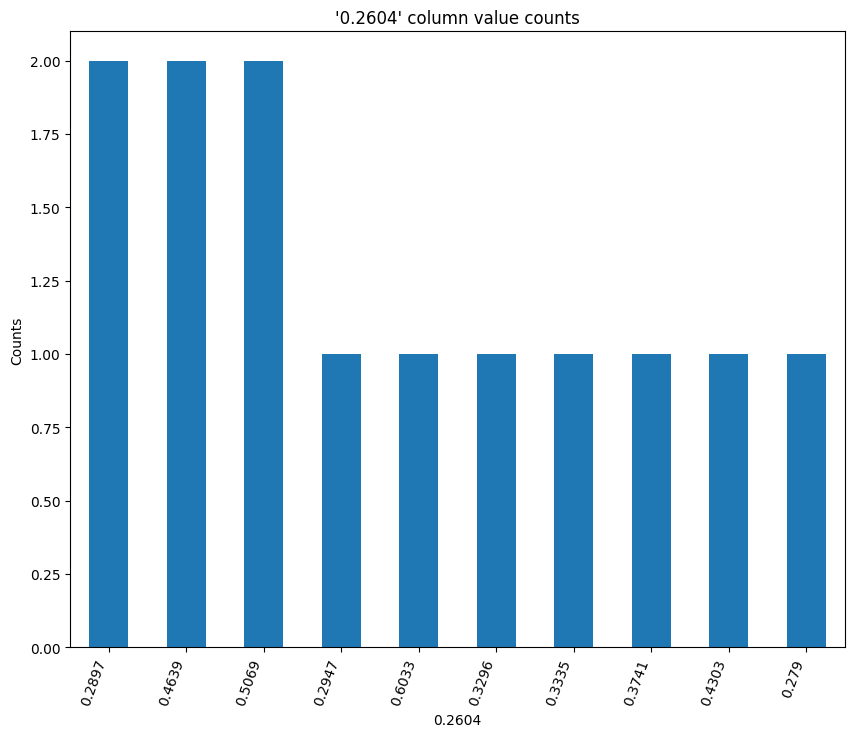

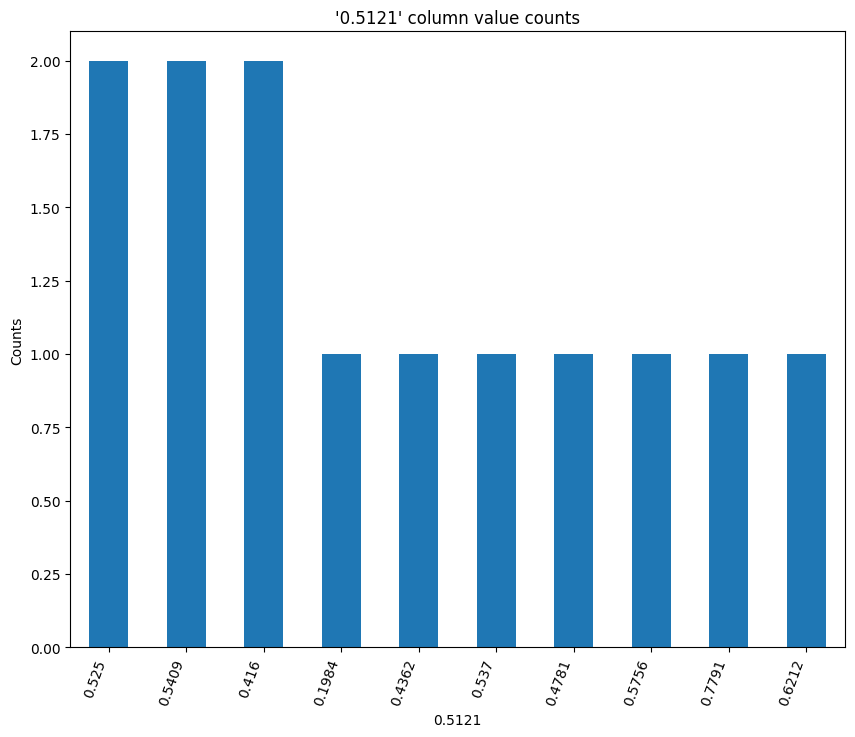

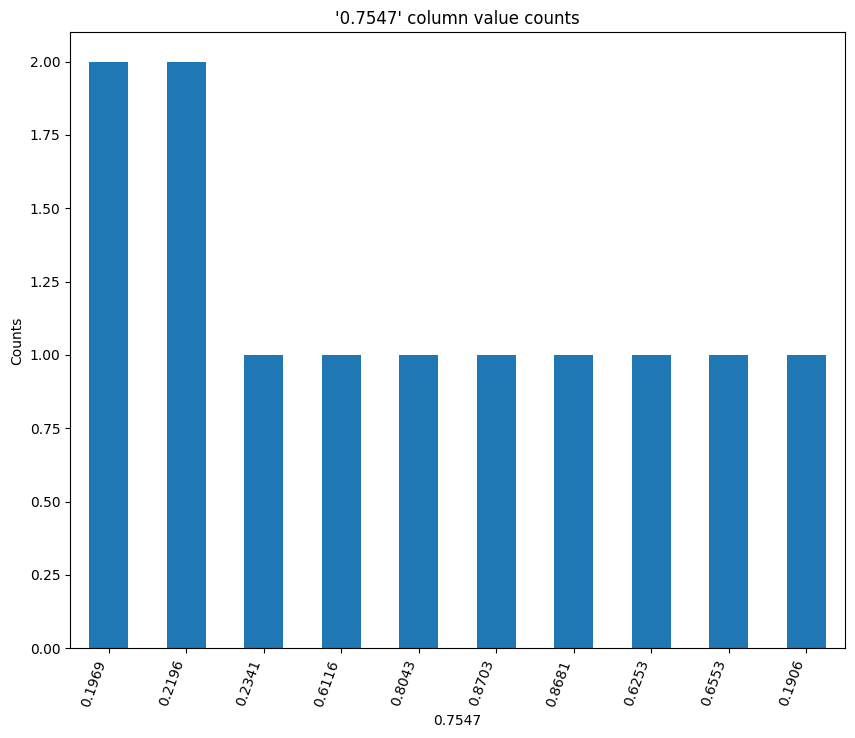

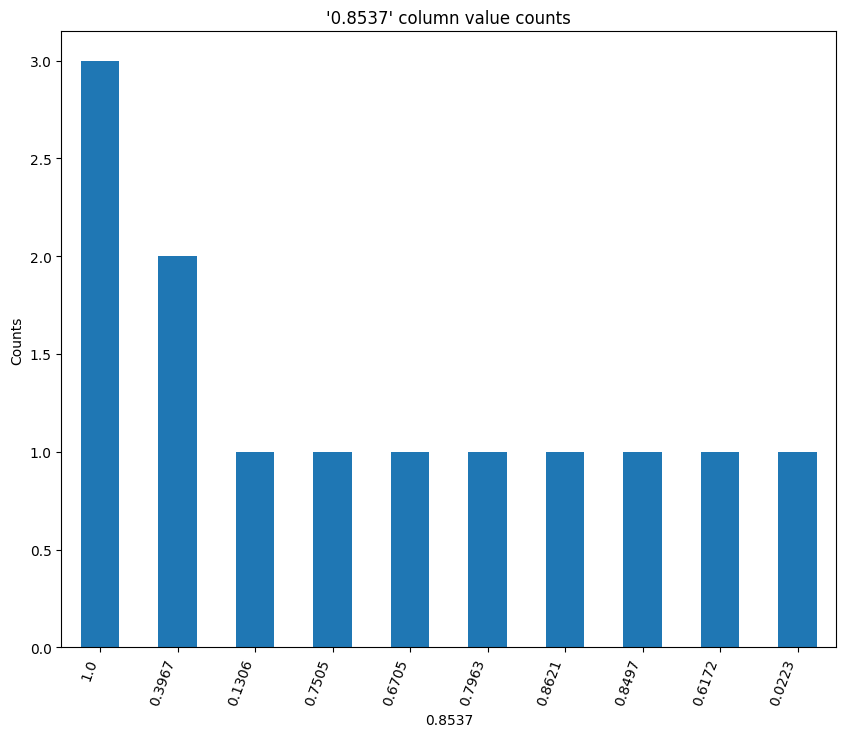

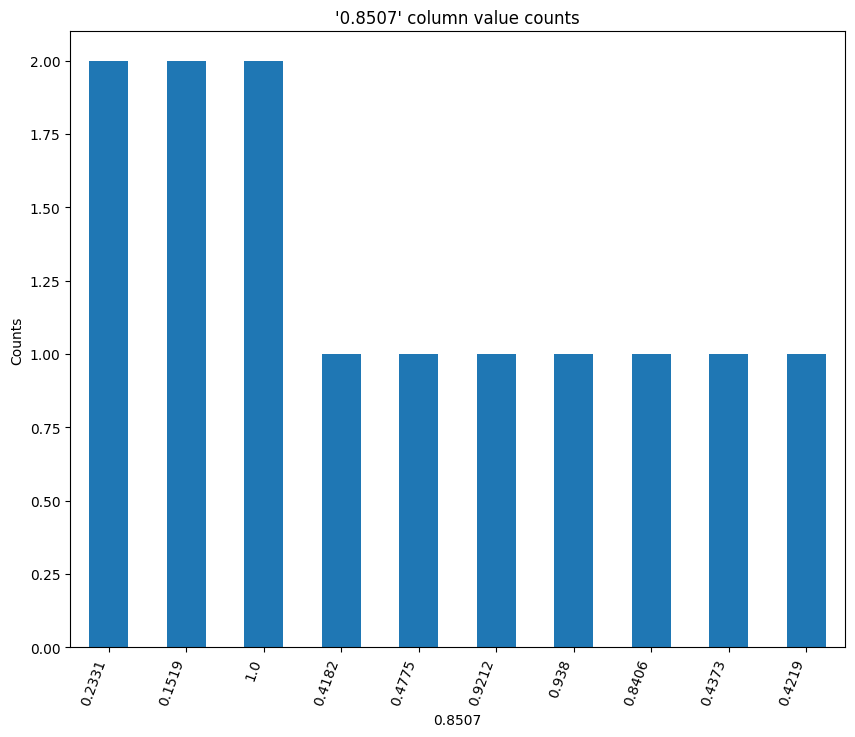

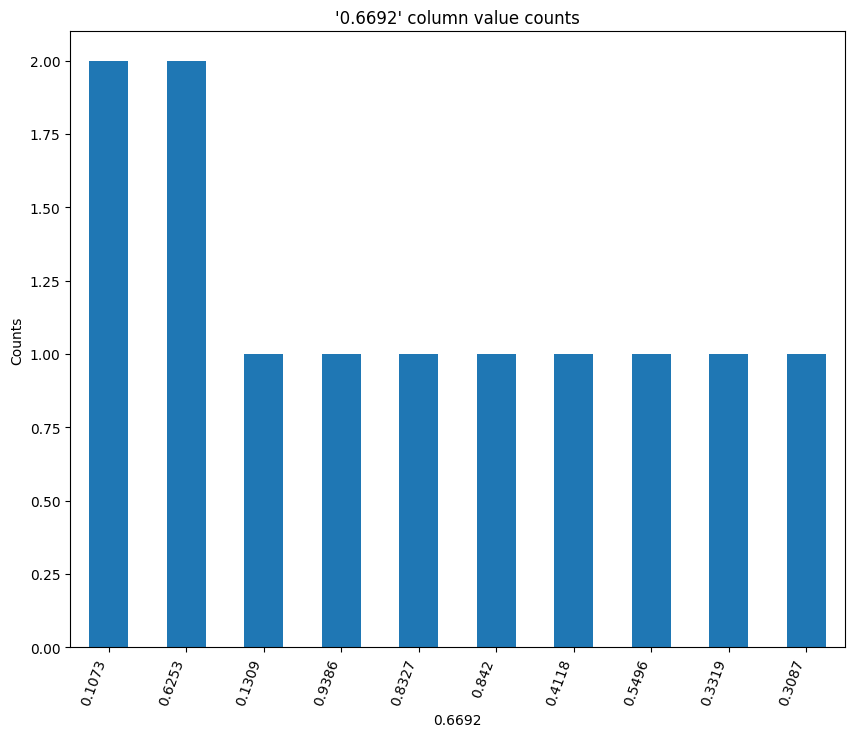

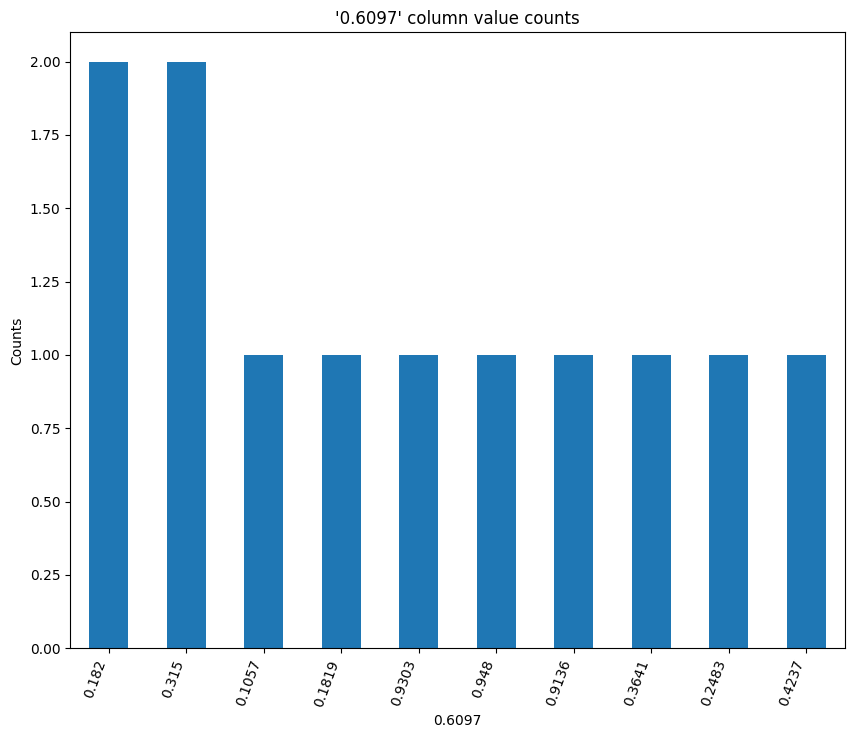

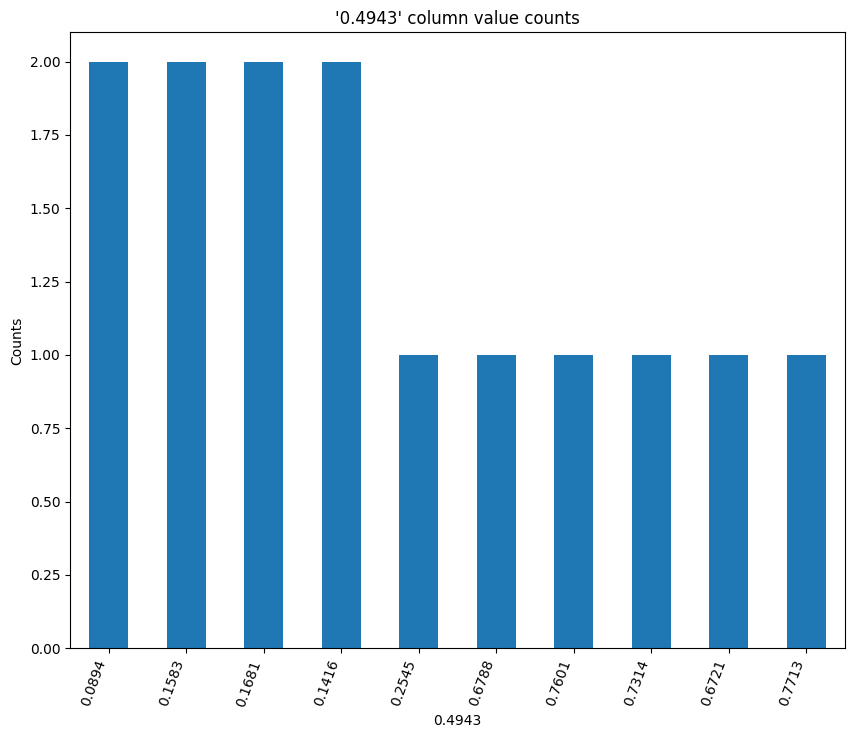

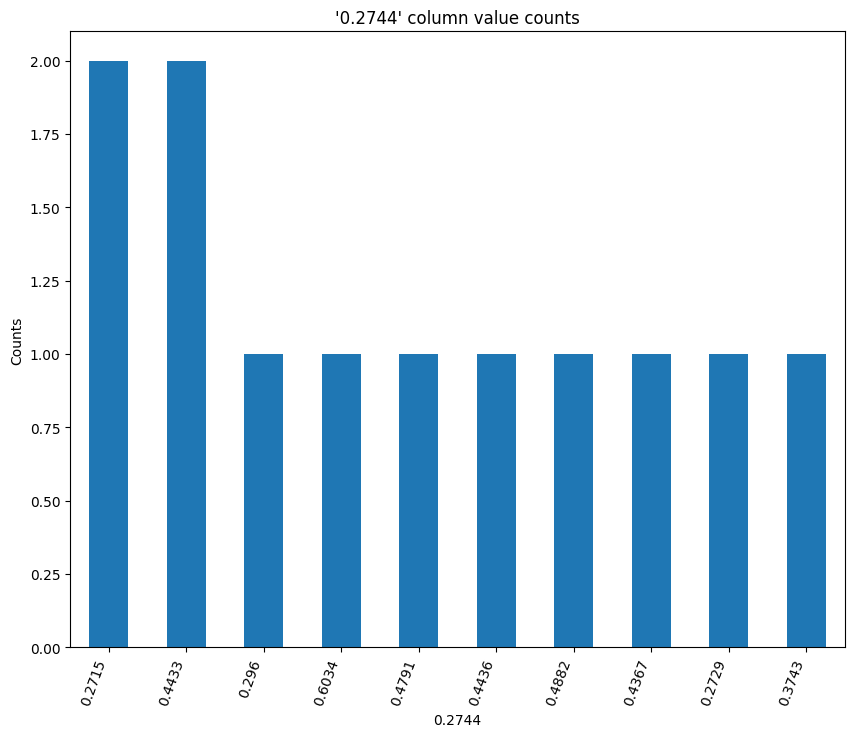

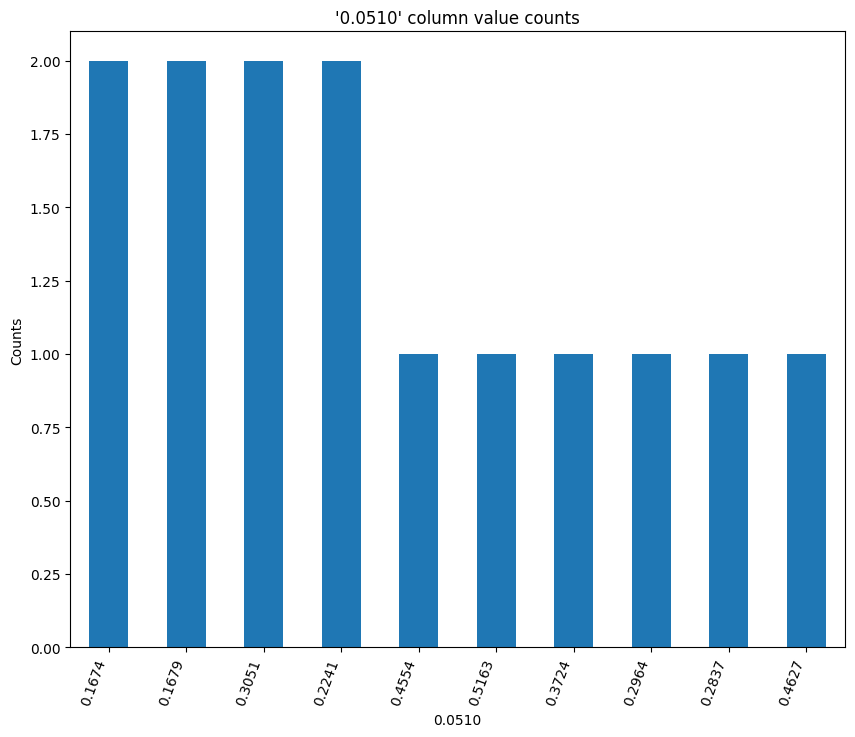

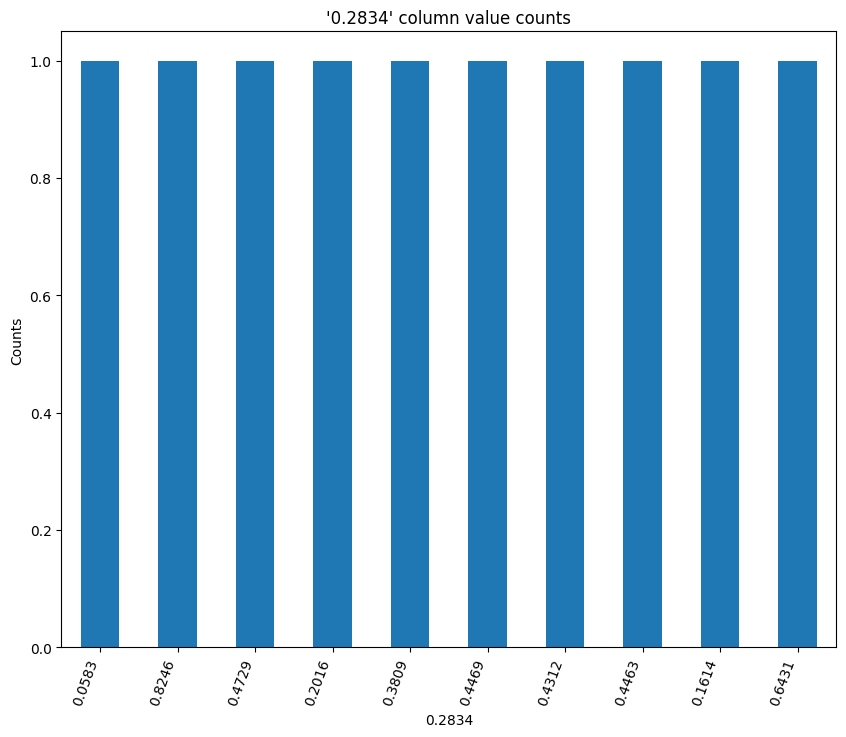

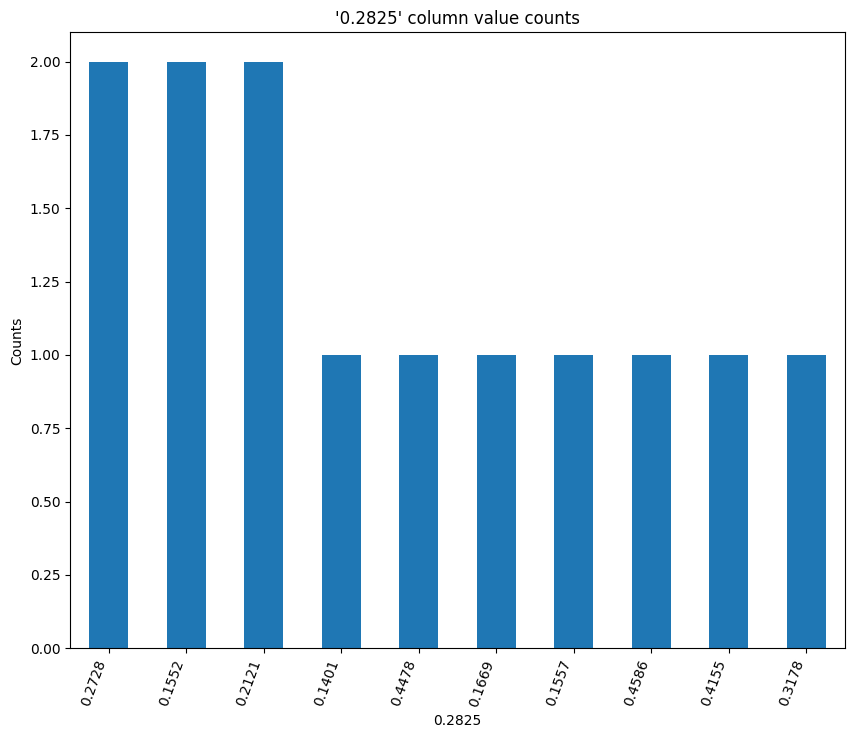

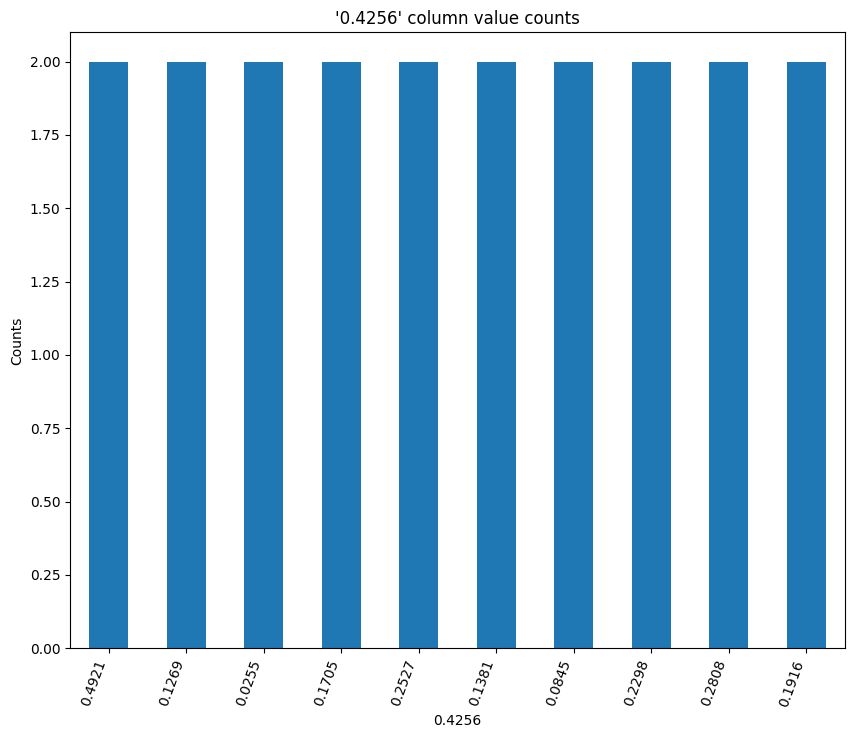

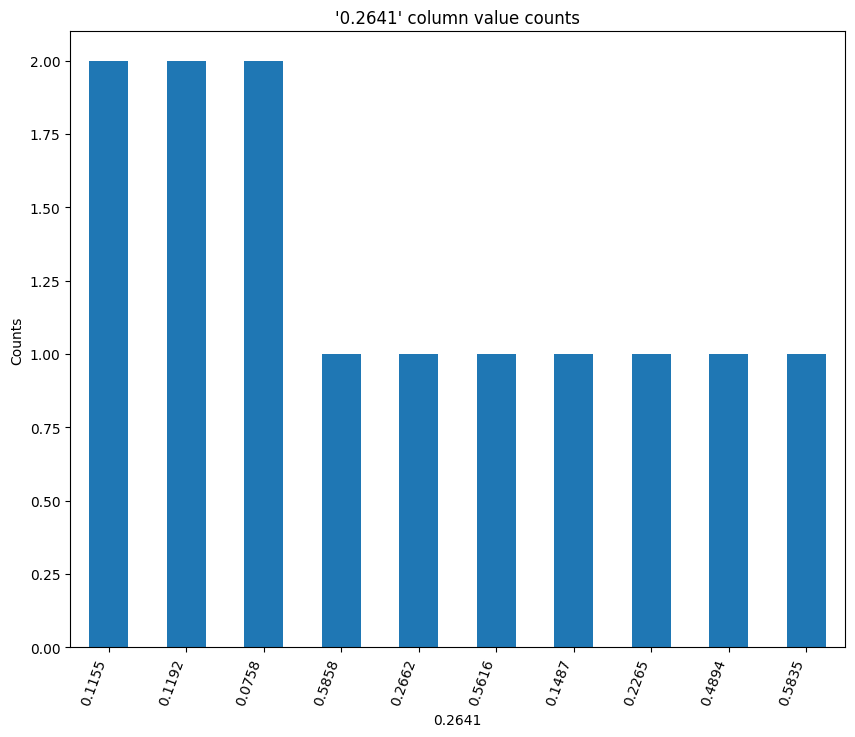

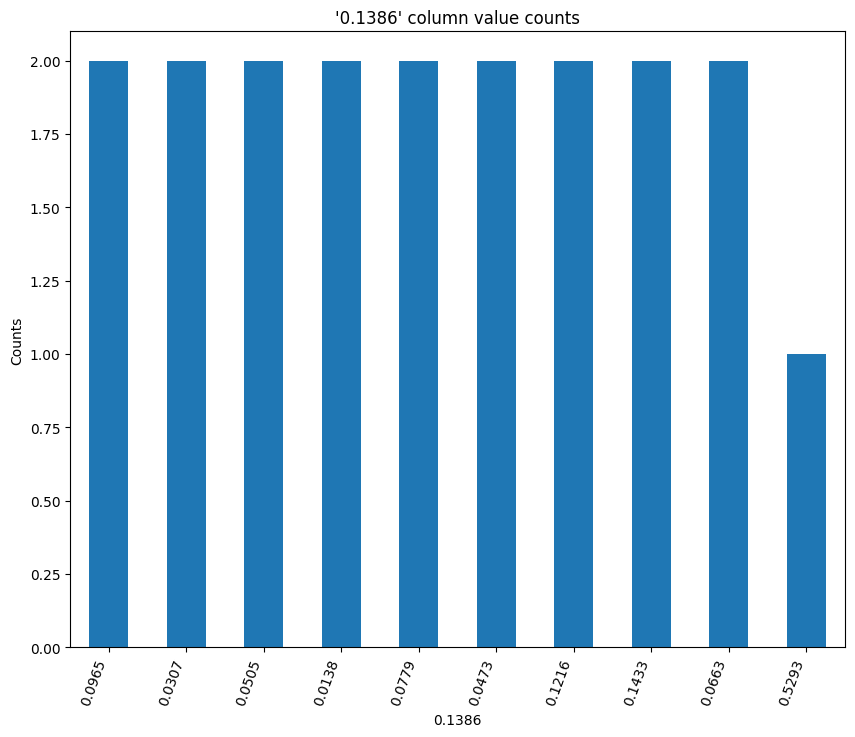

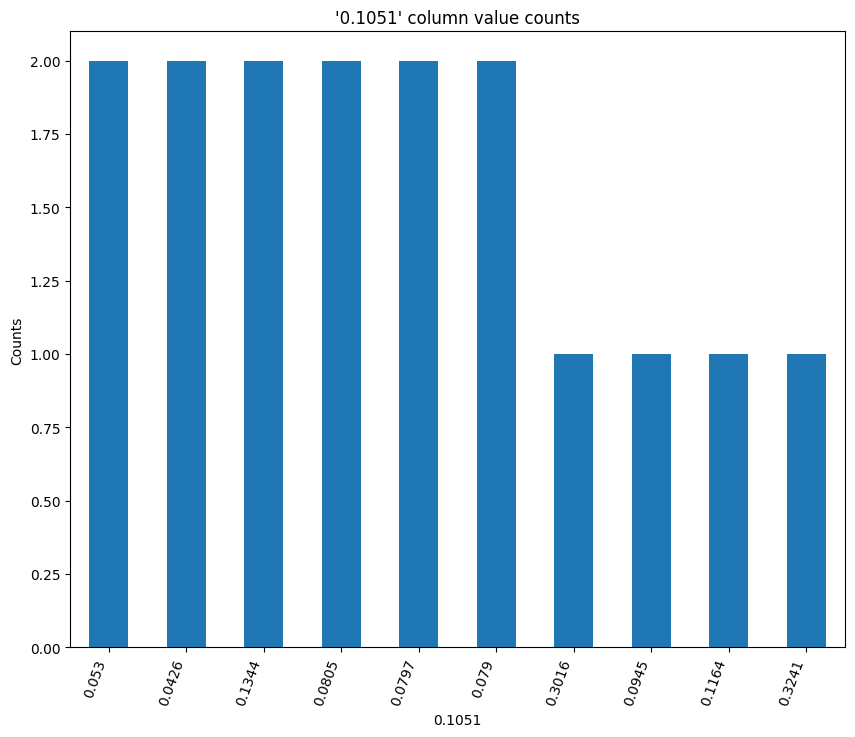

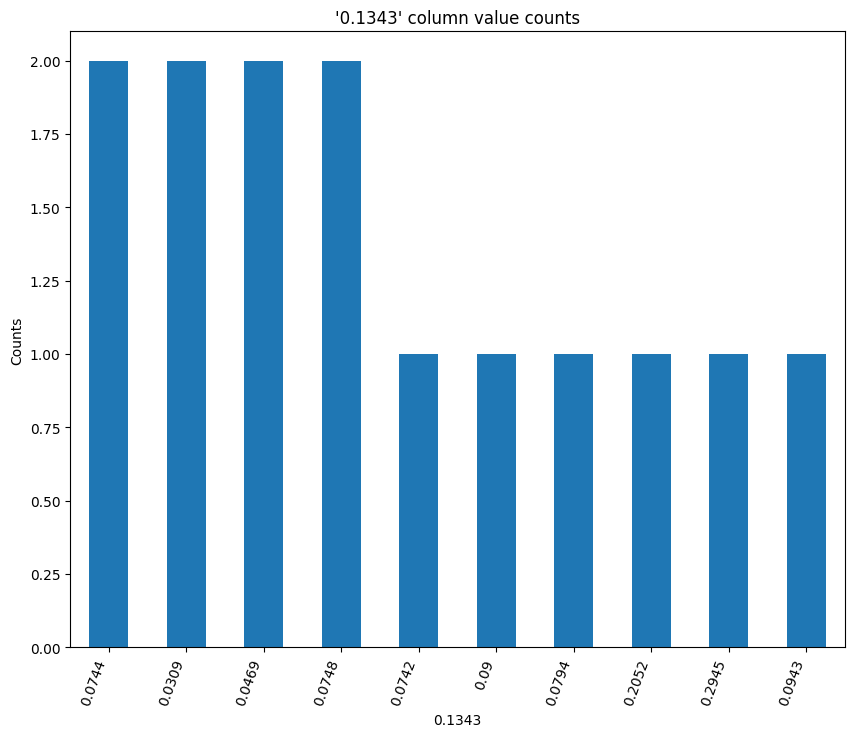

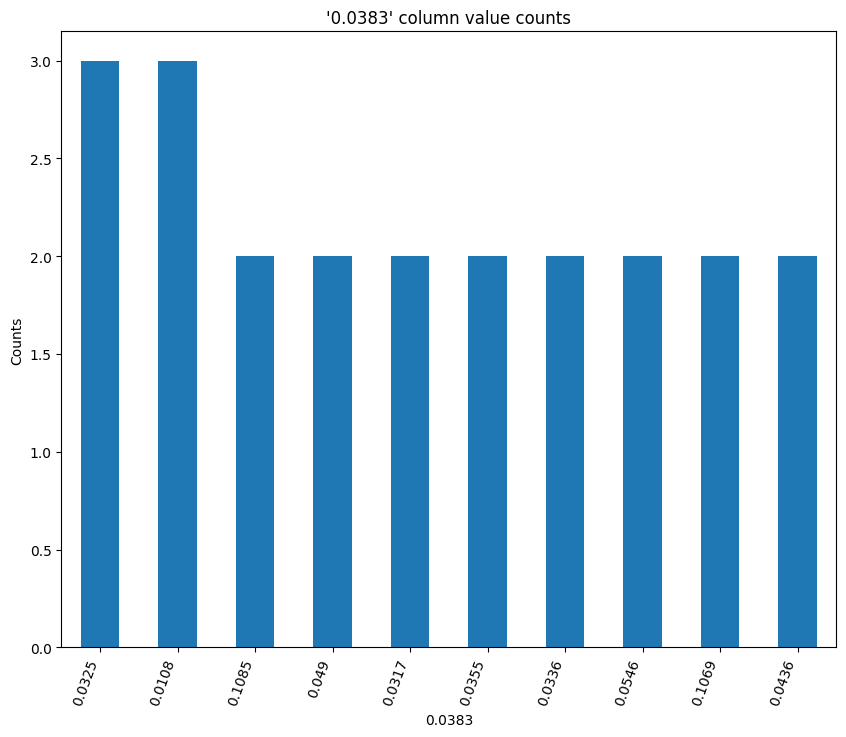

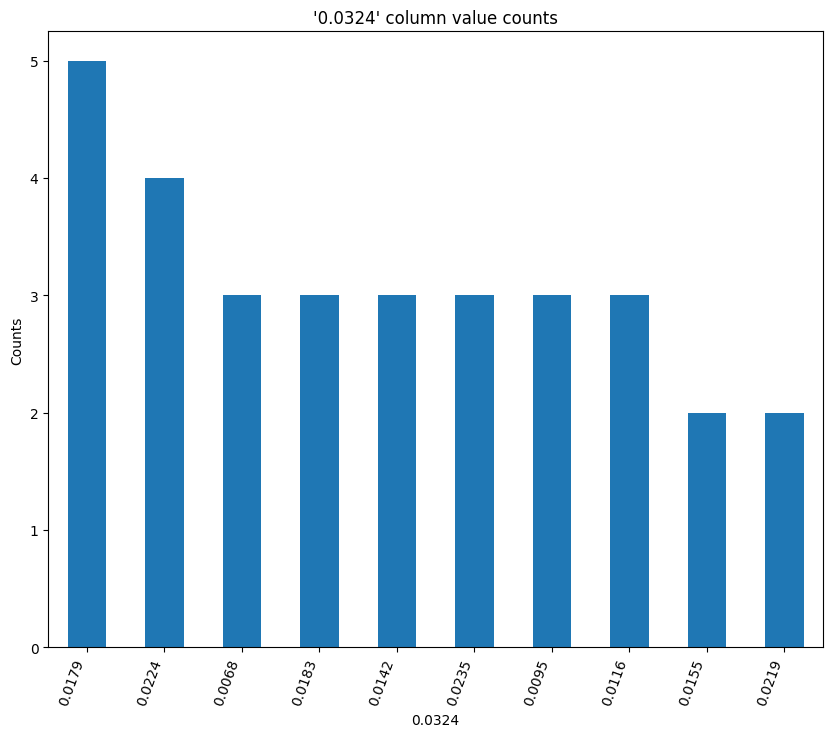

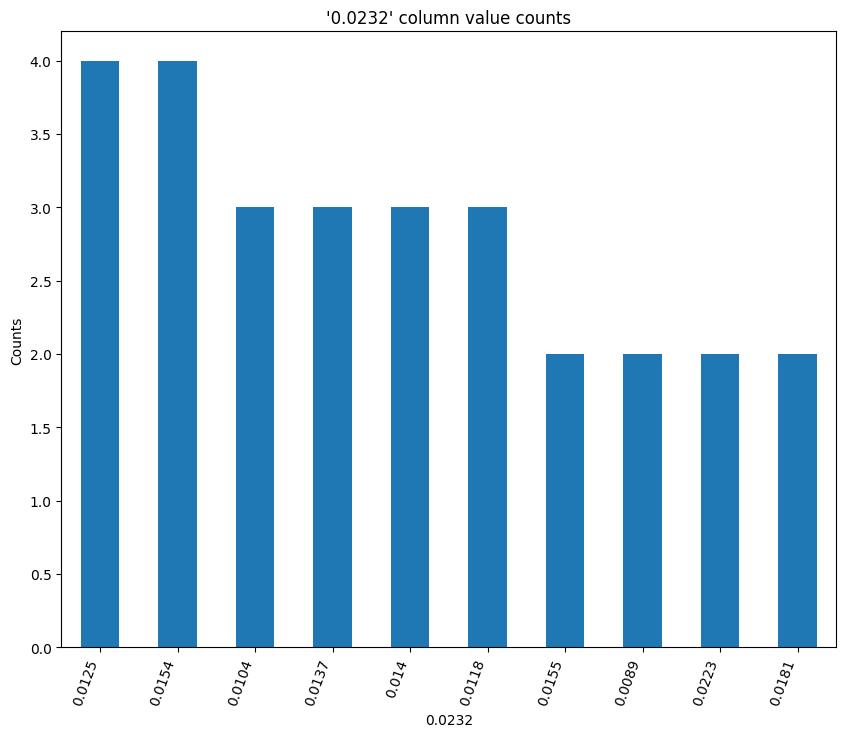

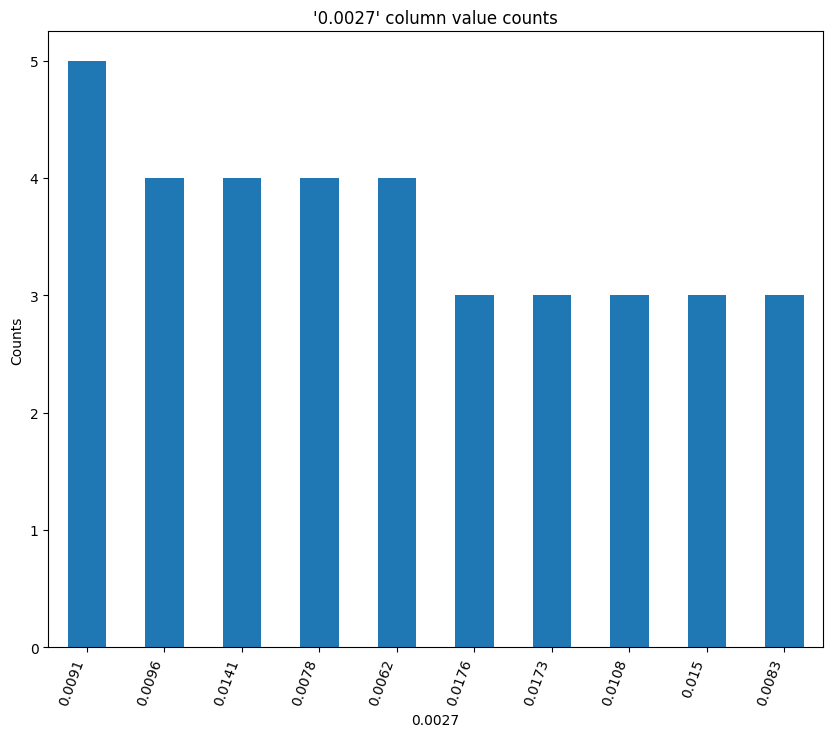

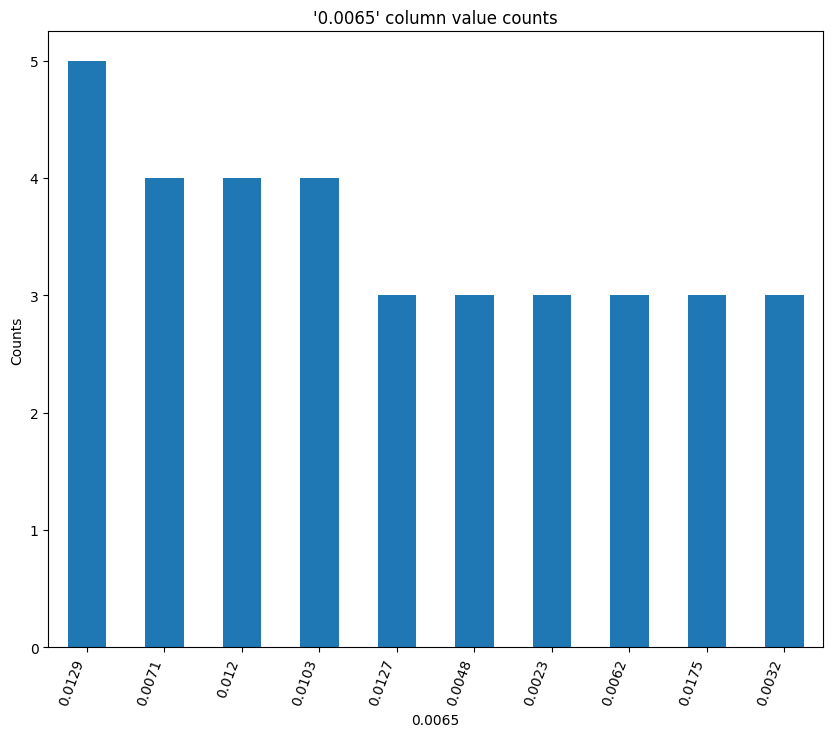

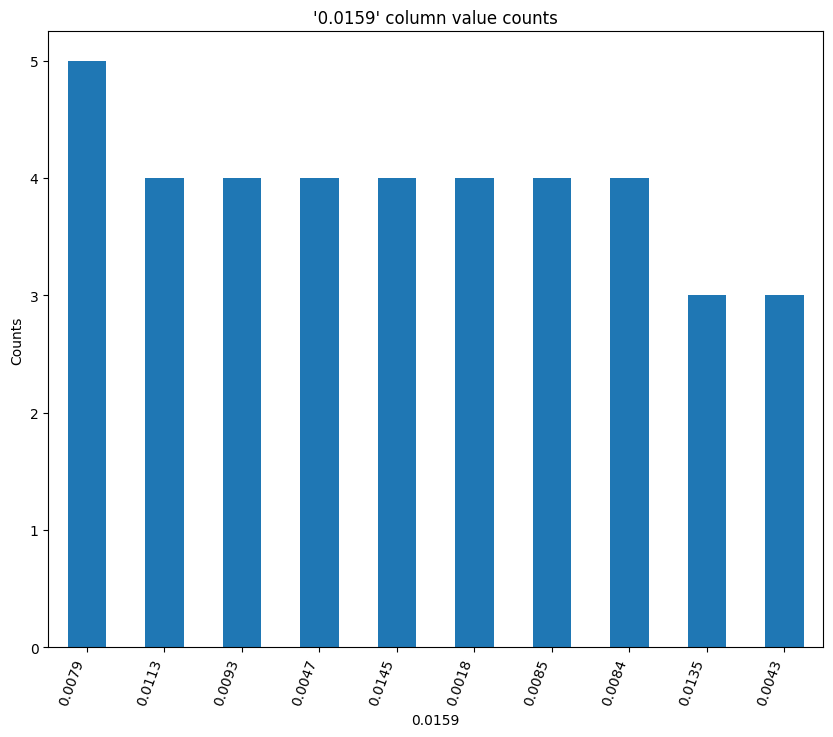

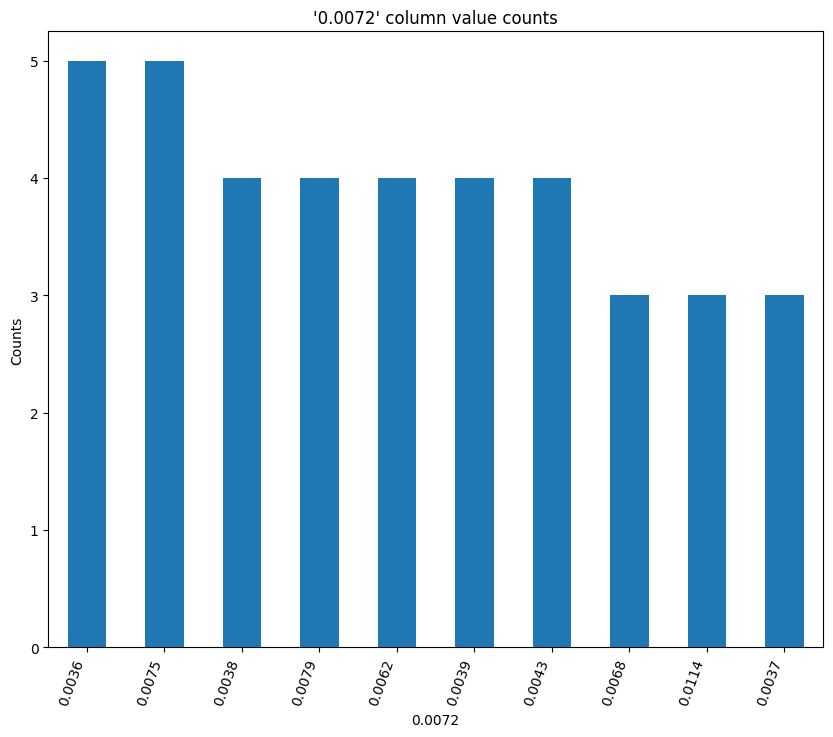

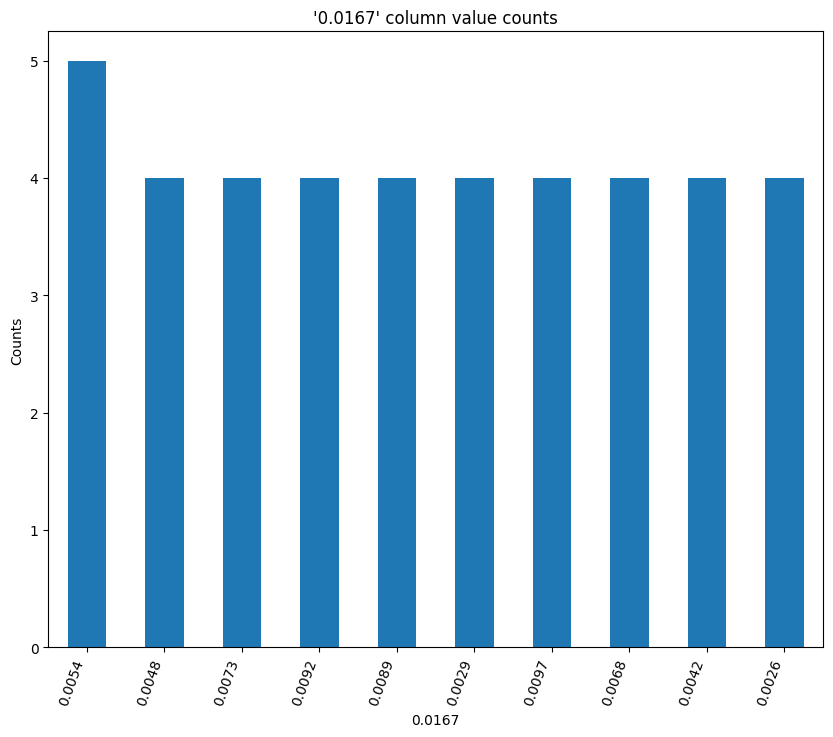

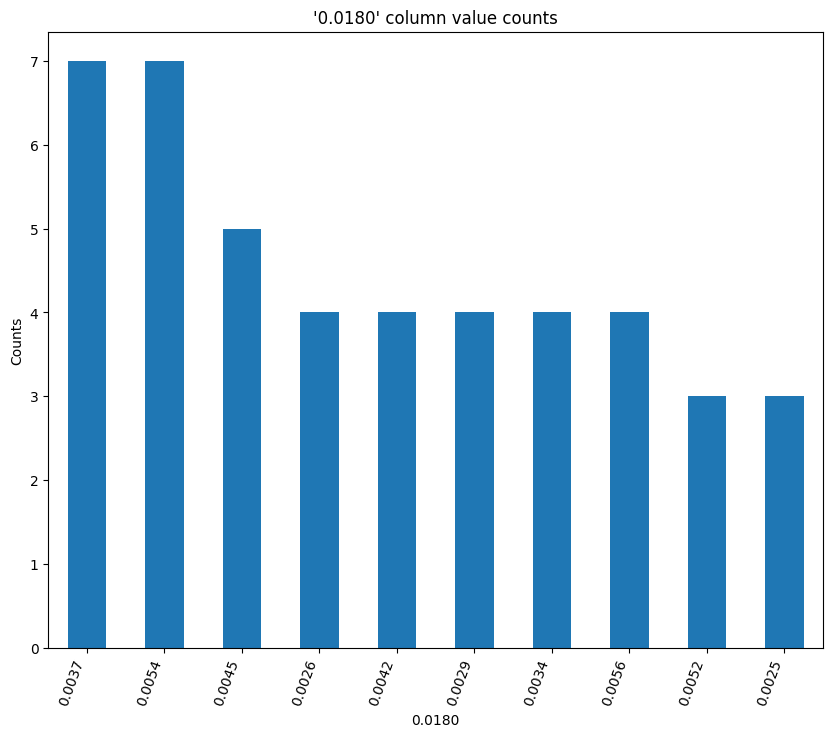

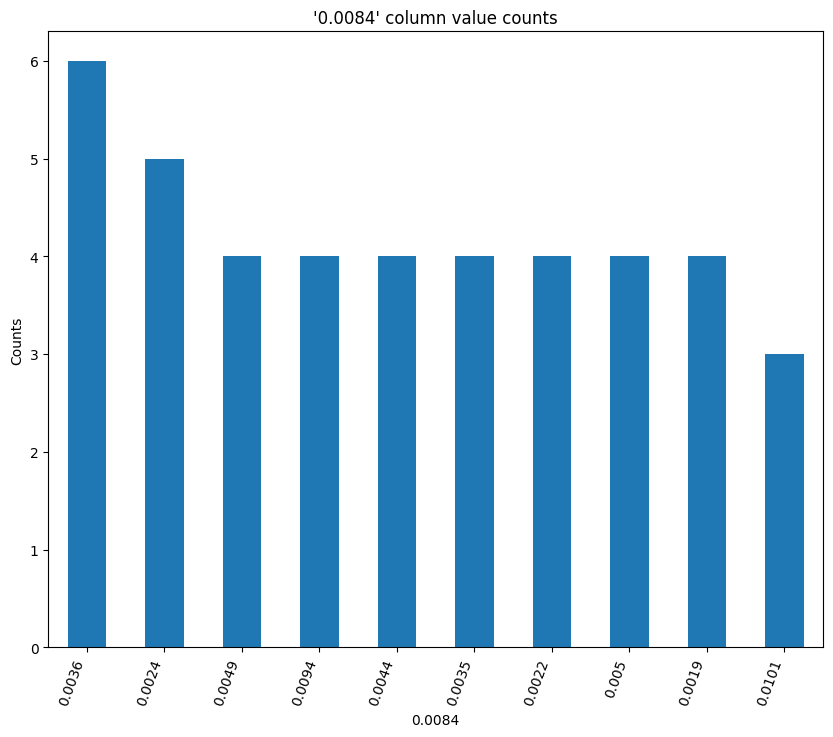

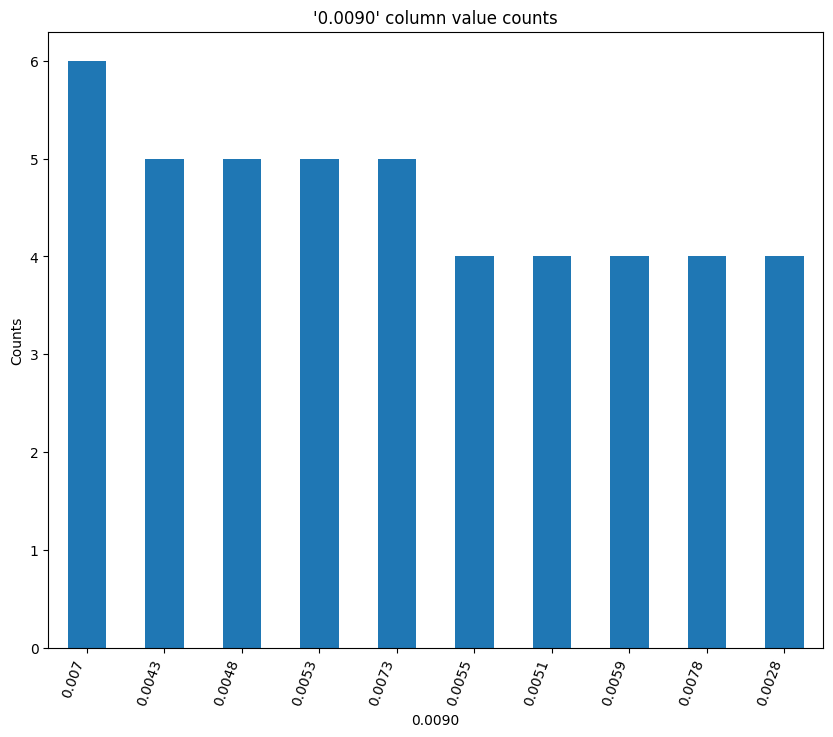

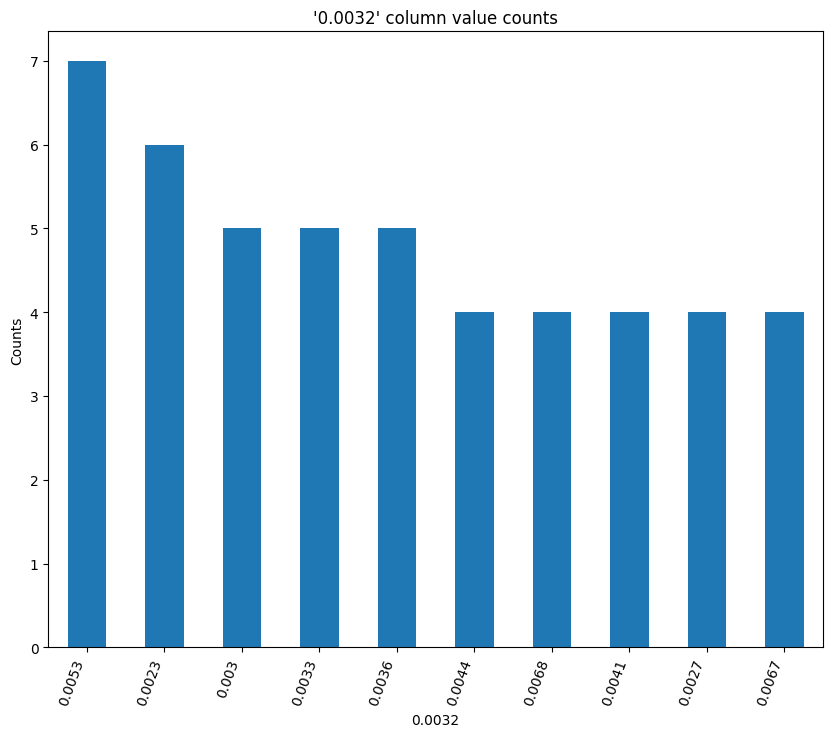

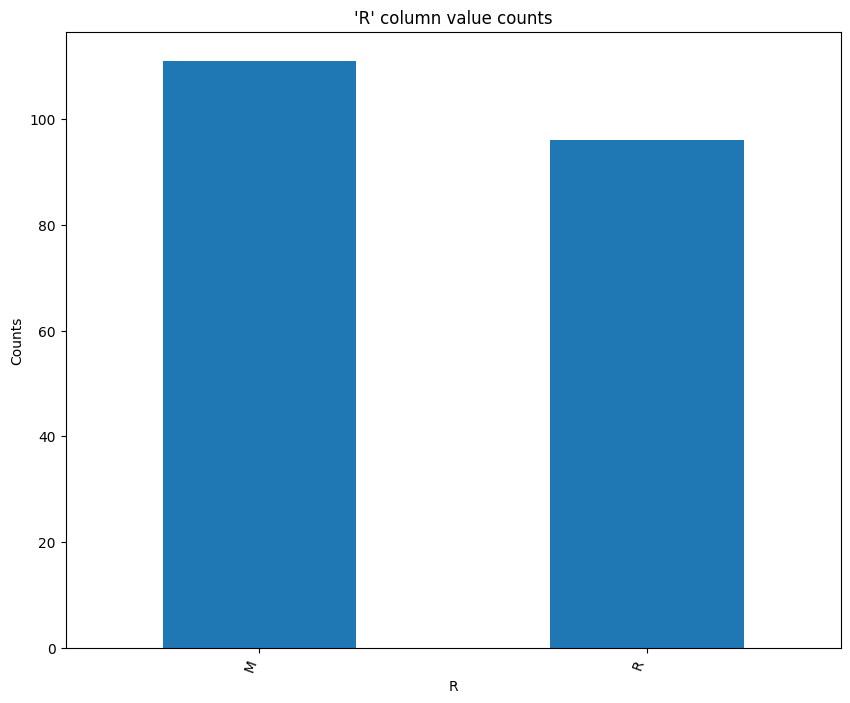

In [5]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

R
M    111
R     96
Name: count, dtype: int64


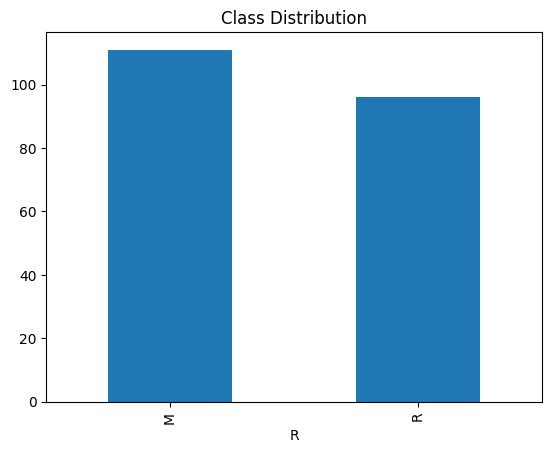

In [6]:
# Value_counts - Unique
objects = df.select_dtypes(include=['object','category'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].value_counts())
    df['R'].value_counts().plot(kind='bar')
    plt.title('Class Distribution')
    plt.show()

In [27]:
# Option A: Label encoding for ordinal data
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    if col != 'R':  # Don't encode your target variable if it's categorical
        df[col] = le.fit_transform(df[col].astype(str))

In [7]:
# Option 1: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [8]:
r = df['R']
r

0      R
1      R
2      R
3      R
4      R
      ..
202    M
203    M
204    M
205    M
206    M
Name: R, Length: 207, dtype: object

In [9]:
df.drop('R', axis=1, inplace=True)

## neural network to imbalanced dataset

In [10]:
# Inspect your dataframe
print(df.dtypes,'\n')  # Check data types of all columns
#print(df.head())  # Look at first few rows
print(df.info())  # Get overview of data types and null values

# Check for non-numeric values
for col in df.columns:
    if df[col].dtype == 'object':  # String columns
        print(f"Column '{col}' contains: {df[col].unique()}")

0.0200       float64
0.0371       float64
0.0428       float64
0.0207       float64
0.0954       float64
              ...   
0.0180       float64
0.0084       float64
0.0090       float64
0.0032       float64
R_encoded      int64
Length: 61, dtype: object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0.0200     207 non-null    float64
 1   0.0371     207 non-null    float64
 2   0.0428     207 non-null    float64
 3   0.0207     207 non-null    float64
 4   0.0954     207 non-null    float64
 5   0.0986     207 non-null    float64
 6   0.1539     207 non-null    float64
 7   0.1601     207 non-null    float64
 8   0.3109     207 non-null    float64
 9   0.2111     207 non-null    float64
 10  0.1609     207 non-null    float64
 11  0.1582     207 non-null    float64
 12  0.2238     207 non-null    float64
 13  0.0645     207 non-null    floa

In [11]:
df.shape

(207, 61)

Feature matrix shape: (207, 60)
Target vector shape: (207,)
Training tensor shapes: X=torch.Size([165, 60]), y=torch.Size([165, 1])
Model input size: 60
Training the model...
Epoch [20/100], Loss: 0.1894, Accuracy: 0.9394
Epoch [40/100], Loss: 0.0498, Accuracy: 0.9758
Epoch [60/100], Loss: 0.0308, Accuracy: 0.9879
Epoch [80/100], Loss: 0.0110, Accuracy: 0.9939
Epoch [100/100], Loss: 0.0301, Accuracy: 0.9939

Test Accuracy: 0.7143
Test Loss: 2.0989


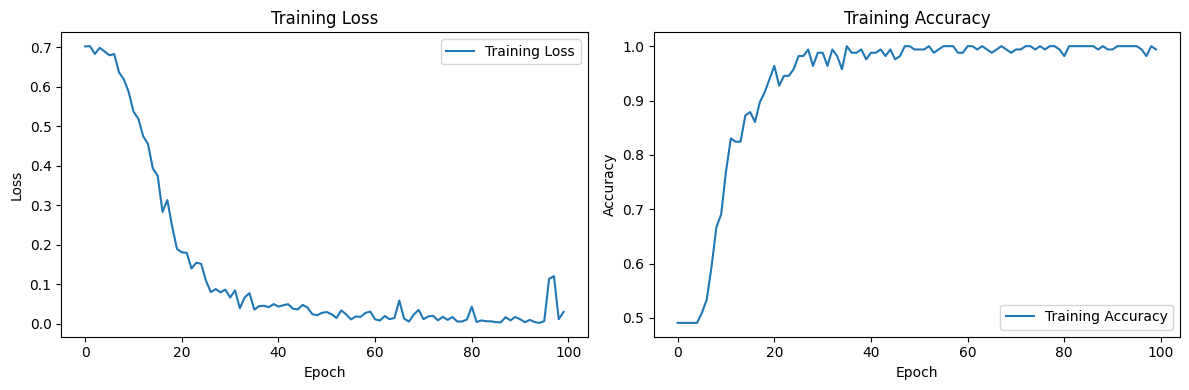


Example predictions:
Sample 1: Probability=0.000, Predicted=0, Actual=0
Sample 2: Probability=0.001, Predicted=0, Actual=1
Sample 3: Probability=1.000, Predicted=1, Actual=1
Sample 4: Probability=1.000, Predicted=1, Actual=0
Sample 5: Probability=1.000, Predicted=1, Actual=0

Model saved!
Predictions from loaded model: [2.8784560e-05 1.1876769e-03 1.0000000e+00 9.9999082e-01 9.9989855e-01]

Total trainable parameters: 6,529
Model architecture:
NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [14]:
# PyTorch real data 

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Features and label
X = df.drop(columns=['R_encoded'])  # This should have 60 columns
y = df['R_encoded']  # This is your target

print(f"Feature matrix shape: {X.shape}")  # Should be (207, 60)
print(f"Target vector shape: {y.shape}")   # Should be (207,)
print('='*127)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

print(f"Training tensor shapes: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model with correct input size (60 features, not 207 or 20)
input_features = X_train_tensor.shape[1]  # This will be 60
model = NeuralNetwork(input_size=input_features, hidden_sizes=[64, 32, 16], output_size=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model input size: {input_features}")
print('='*127) 

# Training loop
num_epochs = 100
train_losses = []
train_accuracies = []

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        # No need to flatten since data is already 2D (batch_size, features)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}') 

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted = (test_outputs > 0.5).float()
    test_accuracy = (test_predicted == y_test_tensor).float().mean()
    test_loss = criterion(test_outputs, y_test_tensor)
    
    print(f'\nTest Accuracy: {test_accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print('='*127) 
    
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions_prob = predictions.numpy()
    predictions_binary = (predictions > 0.5).numpy().astype(int)

print("\nExample predictions:")
for i in range(min(5, len(y_test))):  # Handle case where test set might be small
    prob = predictions_prob[i][0]
    pred_class = predictions_binary[i][0]
    actual_class = y_test.iloc[i]  # Use iloc for pandas Series
    print(f"Sample {i+1}: Probability={prob:.3f}, Predicted={pred_class}, Actual={actual_class}")
    
# Save the model
torch.save(model.state_dict(), 'pytorch_model.pth')
torch.save(model, 'pytorch_model_complete.pth')
print("\nModel saved!")
print('='*127) 

# Load the model - FIXED: Use correct input_size
loaded_model = NeuralNetwork(input_size=input_features, hidden_sizes=[64, 32, 16], output_size=1)
loaded_model.load_state_dict(torch.load('pytorch_model.pth'))
loaded_model.eval()

# Verify loaded model works
with torch.no_grad():
    new_predictions = loaded_model(X_test_tensor[:5])
    print("Predictions from loaded model:", new_predictions.numpy().flatten())
    print('='*127) 
    
# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")
print("Model architecture:")
print(model)

## neural network to balanced dataset

R_encoded
0    111
1     96
Name: count, dtype: int64


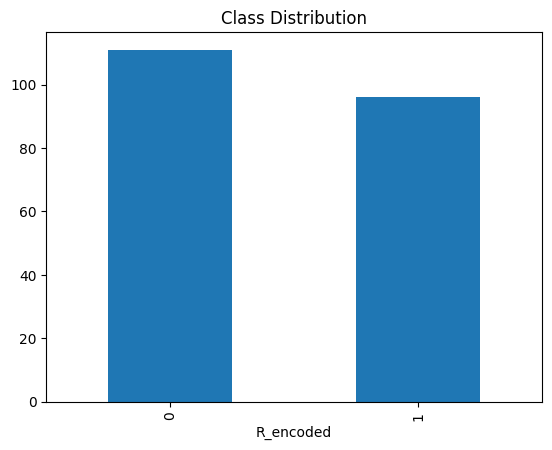

In [15]:
# Imbalance
# Visualize imbalance
print(df['R_encoded'].value_counts())
df['R_encoded'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [16]:
# Oversampling (Increase minority class)
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.R_encoded == 0]
df_minority = df[df.R_encoded == 1]

df_minority_upsampled = resample(df_minority, 
                                replace=True,     # sample with replacement
                                n_samples=len(df_majority),    # to match majority class
                                random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [17]:
# Always reset index (it’s a must to do)
df_balanced = df_balanced.reset_index(drop=True) 

In [18]:
df.head()

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R_encoded
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,0.2988,0.4250,0.6343,0.8198,1.0000,0.9988,0.9508,0.9025,0.7234,0.5122,0.2074,0.3985,0.5890,0.2872,0.2043,0.5782,0.5389,0.3750,0.3411,0.5067,0.5580,0.4778,0.3299,0.2198,0.1407,0.2856,0.3807,0.4158,0.4054,0.3296,0.2707,0.2650,0.0723,0.1238,0.1192,0.1089,0.0623,0.0494,0.0264,0.0081,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,1


R_encoded
0    111
1    111
Name: count, dtype: int64


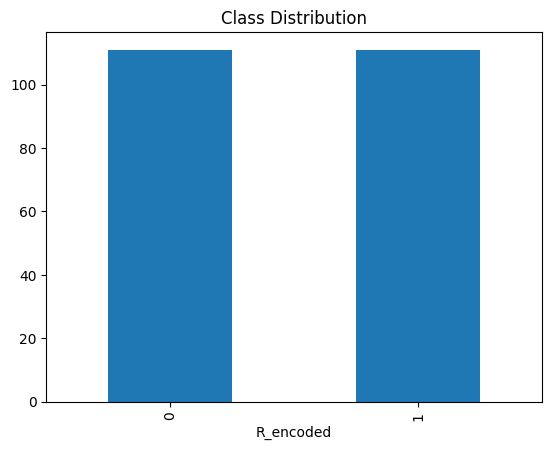

In [19]:
# Imbalance
# Visualize imbalance
print(df_balanced['R_encoded'].value_counts())
df_balanced['R_encoded'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

Feature matrix shape: (222, 60)
Target vector shape: (222,)
Training tensor shapes: X=torch.Size([177, 60]), y=torch.Size([177, 1])
Model input size: 60
Training the model...
Epoch [20/100], Loss: 0.1933, Accuracy: 0.9266
Epoch [40/100], Loss: 0.0278, Accuracy: 0.9944
Epoch [60/100], Loss: 0.0208, Accuracy: 0.9944
Epoch [80/100], Loss: 0.0050, Accuracy: 1.0000
Epoch [100/100], Loss: 0.0047, Accuracy: 1.0000

Test Accuracy: 0.9111
Test Loss: 0.5820


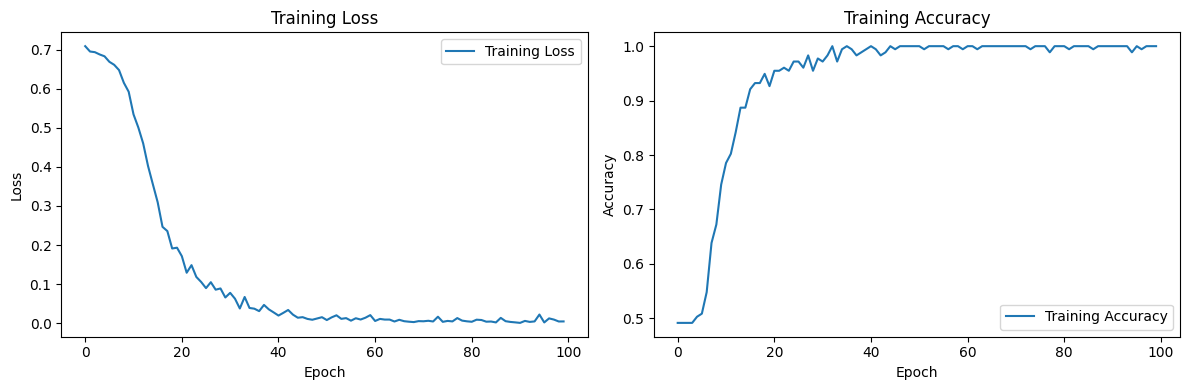


Example predictions:
Sample 1: Probability=1.000, Predicted=1, Actual=1
Sample 2: Probability=0.987, Predicted=1, Actual=1
Sample 3: Probability=0.000, Predicted=0, Actual=0
Sample 4: Probability=1.000, Predicted=1, Actual=1
Sample 5: Probability=0.999, Predicted=1, Actual=1

Model saved!
Predictions from loaded model: [9.9998724e-01 9.8725033e-01 5.1213133e-06 9.9999678e-01 9.9906796e-01]

Total trainable parameters: 6,529
Model architecture:
NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=60, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [20]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Features and label
X = df_balanced.drop(columns=['R_encoded'])  # This should have 60 columns
y = df_balanced['R_encoded']  # This is your target

print(f"Feature matrix shape: {X.shape}")  # Should be (207, 60)
print(f"Target vector shape: {y.shape}")   # Should be (207,)
print('='*127)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

print(f"Training tensor shapes: X={X_train_tensor.shape}, y={y_train_tensor.shape}")

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model with correct input size (60 features, not 207 or 20)
input_features = X_train_tensor.shape[1]  # This will be 60
model = NeuralNetwork(input_size=input_features, hidden_sizes=[64, 32, 16], output_size=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model input size: {input_features}")
print('='*127) 

# Training loop
num_epochs = 100
train_losses = []
train_accuracies = []

print("Training the model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        # No need to flatten since data is already 2D (batch_size, features)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}') 

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted = (test_outputs > 0.5).float()
    test_accuracy = (test_predicted == y_test_tensor).float().mean()
    test_loss = criterion(test_outputs, y_test_tensor)
    
    print(f'\nTest Accuracy: {test_accuracy:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print('='*127) 
    
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions_prob = predictions.numpy()
    predictions_binary = (predictions > 0.5).numpy().astype(int)

print("\nExample predictions:")
for i in range(min(5, len(y_test))):  # Handle case where test set might be small
    prob = predictions_prob[i][0]
    pred_class = predictions_binary[i][0]
    actual_class = y_test.iloc[i]  # Use iloc for pandas Series
    print(f"Sample {i+1}: Probability={prob:.3f}, Predicted={pred_class}, Actual={actual_class}")
    
# Save the model
torch.save(model.state_dict(), 'pytorch_model.pth')
torch.save(model, 'pytorch_model_complete.pth')
print("\nModel saved!")
print('='*127) 

# Load the model - FIXED: Use correct input_size
loaded_model = NeuralNetwork(input_size=input_features, hidden_sizes=[64, 32, 16], output_size=1)
loaded_model.load_state_dict(torch.load('pytorch_model.pth'))
loaded_model.eval()

# Verify loaded model works
with torch.no_grad():
    new_predictions = loaded_model(X_test_tensor[:5])
    print("Predictions from loaded model:", new_predictions.numpy().flatten())
    print('='*127) 
    
# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")
print("Model architecture:")
print(model)

In [21]:
df_balanced

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R_encoded
0,0.0491,0.0279,0.0592,0.1270,0.1772,0.1908,0.2217,0.0768,0.1246,0.2028,0.0947,0.2497,0.2209,0.3195,0.3340,0.3323,0.2780,0.2975,0.2948,0.1729,0.3264,0.3834,0.3523,0.5410,0.5228,0.4475,0.5340,0.5323,0.3907,0.3456,0.4091,0.4639,0.5580,0.5727,0.6355,0.7563,0.6903,0.6176,0.5379,0.5622,0.6508,0.4797,0.3736,0.2804,0.1982,0.2438,0.1789,0.1706,0.0762,0.0238,0.0268,0.0081,0.0129,0.0161,0.0063,0.0119,0.0194,0.0140,0.0332,0.0439,0
1,0.1313,0.2339,0.3059,0.4264,0.4010,0.1791,0.1853,0.0055,0.1929,0.2231,0.2907,0.2259,0.3136,0.3302,0.3660,0.3956,0.4386,0.4670,0.5255,0.3735,0.2243,0.1973,0.4337,0.6532,0.5070,0.2796,0.4163,0.5950,0.5242,0.4178,0.3714,0.2375,0.0863,0.1437,0.2896,0.4577,0.3725,0.3372,0.3803,0.4181,0.3603,0.2711,0.1653,0.1951,0.2811,0.2246,0.1921,0.1500,0.0665,0.0193,0.0156,0.0362,0.0210,0.0154,0.0180,0.0013,0.0106,0.0127,0.0178,0.0231,0
2,0.0201,0.0423,0.0554,0.0783,0.0620,0.0871,0.1201,0.2707,0.1206,0.0279,0.2251,0.2615,0.1770,0.3709,0.4533,0.5553,0.4616,0.3797,0.3450,0.2665,0.2395,0.1127,0.2556,0.5169,0.3779,0.4082,0.5353,0.5116,0.4544,0.4258,0.3869,0.3939,0.4661,0.3974,0.2194,0.1816,0.1023,0.2108,0.3253,0.3697,0.2912,0.3010,0.2563,0.1927,0.2062,0.1751,0.0841,0.1035,0.0641,0.0153,0.0081,0.0191,0.0182,0.0160,0.0290,0.0090,0.0242,0.0224,0.0190,0.0096,0
3,0.0629,0.1065,0.1526,0.1229,0.1437,0.1190,0.0884,0.0907,0.2107,0.3597,0.5466,0.5205,0.5127,0.5395,0.6558,0.8705,0.9786,0.9335,0.7917,0.7383,0.6908,0.3850,0.0671,0.0502,0.2717,0.2839,0.2234,0.1911,0.0408,0.2531,0.1979,0.1891,0.2433,0.1956,0.2667,0.1340,0.1073,0.2023,0.1794,0.0227,0.1313,0.1775,0.1549,0.1626,0.0708,0.0129,0.0795,0.0762,0.0117,0.0061,0.0257,0.0089,0.0262,0.0108,0.0138,0.0187,0.0230,0.0057,0.0113,0.0131,0
4,0.0335,0.0134,0.0696,0.1180,0.0348,0.1180,0.1948,0.1607,0.3036,0.4372,0.5533,0.5771,0.7022,0.7067,0.7367,0.7391,0.8622,0.9458,0.8782,0.7913,0.5760,0.3061,0.0563,0.0239,0.2554,0.4862,0.5027,0.4402,0.2847,0.1797,0.3560,0.3522,0.3321,0.3112,0.3638,0.0754,0.1834,0.1820,0.1815,0.1593,0.0576,0.0954,0.1086,0.0812,0.0784,0.0487,0.0439,0.0586,0.0370,0.0185,0.0302,0.0244,0.0232,0.0093,0.0159,0.0193,0.0032,0.0377,0.0126,0.0156,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.0235,0.0291,0.0749,0.0519,0.0227,0.0834,0.0677,0.2002,0.2876,0.3674,0.2974,0.0837,0.1912,0.5040,0.6352,0.6804,0.7505,0.6595,0.4509,0.2964,0.4019,0.6794,0.8297,1.0000,0.8240,0.7115,0.7726,0.6124,0.4936,0.5648,0.4906,0.1820,0.1811,0.1107,0.4603,0.6650,0.6423,0.2166,0.1951,0.4947,0.4925,0.4041,0.2402,0.1392,0.1779,0.1946,0.1723,0.1522,0.0929,0.0179,0.0242,0.0083,0.0037,0.0095,0.0105,0.0030,0.0132,0.0068,0.0108,0.0090,1
218,0.0036,0.0078,0.0092,0.0387,0.0530,0.1197,0.1243,0.1026,0.1239,0.0888,0.0937,0.1245,0.1599,0.1542,0.1846,0.1732,0.1477,0.1748,0.1455,0.1579,0.2257,0.1975,0.3368,0.5828,0.8505,1.0000,0.8457,0.6624,0.5564,0.3925,0.3233,0.2054,0.1920,0.2227,0.3147,0.2268,0.0795,0.0748,0.1166,0.1969,0.2619,0.2507,0.1983,0.0948,0.0931,0.0965,0.0381,0.0435,0.0336,0.0055,0.0079,0.0119,0.0055,0.0035,0.0036,0.0004,0.0018,0.0049,0.0024,0.0016,1
219,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,0.0801,0.1056,0.1266,0.0890,0.0198,0.1133,0.2826,0.3234,0.3238,0.4333,0.6068,0.7652,0.9203,0.9719,0.9207,0.7545,0.8289,0.8907,0.7309,0.6896,0.5829,0.4935,0.3101,0.0306,0.0244,0.1108,0.1594,0.1371,0.0696,0.0452,0.0620,0.1421,0.1597,0.1384,0.0372,0.0688,0.0867,0.0513,0.0092,0.